In [11]:
import pickle
import os
import pandas as pd
from matplotlib import pyplot as plt
os.chdir(os.path.expanduser('~/wcEcoli/'))
# noinspection PyUnresolvedReferences
from wholecell.io.tablereader import TableReader
import io
import numpy as np
from wholecell.io import tsv
from wholecell.utils.filepath import ROOT_PATH
import plotly.graph_objects as go
from models.ecoli.analysis import cohortAnalysisPlot
from wholecell.analysis.analysis_tools import (exportFigure,
	read_bulk_molecule_counts, read_stacked_bulk_molecules, read_stacked_columns)
from wholecell.io.tablereader import TableReader
from sklearn.metrics import r2_score
import plotly.graph_objects as go
import seaborn as sns
import glob
import plotly.express as px

# Specify the data sequences to compare

In [18]:
# Name the sequences to use:
current_sequence = "Clim4_annotated"
CLNE_sequence = "CLNE3"
branch_name = "pd-half-life-debug"

some functions that will be used for data processing: 

In [2]:
# function to match gene symbols to monomer ids
def get_gene_symbols_for_monomer_ids():
	"""
	Extracts the gene symbols for each monomer id in the model.
	Returns: a dictionary mapping monomer ids to gene symbols.
	Code adapted from convert_to_flat.py.
	"""
	RNAS_FILE = os.path.join(ROOT_PATH, 'reconstruction', 'ecoli',
								 'flat', 'rnas.tsv')
	with (io.open(RNAS_FILE, 'rb') as f):
		reader = tsv.reader(f, delimiter='\t')
		headers = next(reader)
		while headers[0].startswith('#'):
			headers = next(reader)

		# extract relevant information
		gene_symbol_index = headers.index('common_name')
		protein_id_index = headers.index('monomer_ids')
		monomer_ids_to_gene_symbols = {}
		for line in reader:
			gene_symbol = line[gene_symbol_index]
			protein_id = list(
				line[protein_id_index][2:-2].split('", "'))[0]
			monomer_ids_to_gene_symbols[protein_id] = gene_symbol

	return monomer_ids_to_gene_symbols

def get_common_name(protein_id):
    """
    Get the common name of a protein given its monomer id.
    Args:
        protein_id: the name of the monomer

    Returns:
        common_name: The common name of the protein.

    """
    # remove the compartment tag first if it exists:
    if '[' in protein_id:
        protein_id = protein_id[:-3]  # subtract the compartment
        common_name = get_gene_symbols_for_monomer_ids()[protein_id]
    else:
        common_name = get_gene_symbols_for_monomer_ids()[protein_id]
    return common_name

# Read in all the data


In [3]:


# read in the CLNE (2020 model) half life data: 
CLNE1_HLs = f"out/{CLNE_sequence}/kb_plot_out/protein_half_lives.tsv"
CLNE1_HLs = pd.read_csv(CLNE1_HLs, sep='\t')
CLNE1_HLs = CLNE1_HLs.rename(columns={"half_life_(min)": "original_half_life"})
CLNE1_HLs = CLNE1_HLs.drop(columns={"degradation_rate(1/s)", "degradation_rate_source"})

# read in the CLClim3NE (2025 model) half life data:
CLClim3NE1_HLs = f"out/{current_sequence}/kb_plot_out/protein_half_lives.tsv"
CLClim3NE1_HLs = pd.read_csv(CLClim3NE1_HLs, sep='\t')
CLClim3NE1_HLs = CLClim3NE1_HLs.rename(columns={"half_life_(min)": "new_half_life"})
CLClim3NE1_HLs = CLClim3NE1_HLs.drop(columns={"degradation_rate(1/s)", "degradation_rate_source"})

# merge the two together: 
combined_df = pd.merge(CLClim3NE1_HLs, CLNE1_HLs, on='monomer_id', how='inner')

# add the common names to the dataframe:
combined_df['common_name'] = None
for index, row in combined_df.iterrows():
    common_name = get_common_name(row['monomer_id'])
    combined_df.at[index, 'common_name'] = common_name

# add the counts data: 
CLNE_new_name = "Log10 " +CLNE_sequence +" Average Monomer Counts"
CLClimNE_new_name = "Log10 " +current_sequence +" Average Monomer Counts"

# read in the unfiltered data and remove the last three characters from each entry in the Monomer ID column: 
CLClimNE_log_data = pd.read_csv(
    f'out/{current_sequence}/wildtype_000000/cohort_average_monomer_count_data/unfiltered_data/log_data/LogAvgProteinCounts_startGen_2.csv')
CLClimNE_log_data['Monomer ID'] = CLClimNE_log_data['Monomer ID'].str[:-3]

# do the same for the 2020 model:
CLNE_log_data = pd.read_csv('/Users/miagrahn/wcEcoli/out/CLNE_11192024/wildtype_000000/cohort_average_monomer_count_data/unfiltered_data/log_data/LogAvgProteinCounts_startGen_2.csv')
CLNE_log_data['Monomer ID'] = CLNE_log_data['Monomer ID'].str[:-3]

# merge the two dataframes:
CLNE_log_data = CLNE_log_data.rename(columns={"Log10 Average Monomer Counts": CLNE_new_name})
CLClimNE_log_data = CLClimNE_log_data.rename(columns={"Log10 Average Monomer Counts": CLClimNE_new_name})
CLNE_log_data = CLNE_log_data.set_index("Monomer ID")
CLClimNE_log_data = CLClimNE_log_data.set_index("Monomer ID")
# CLNE_log_data = CLNE_log_data.reset_index()
# CLClimNE_log_data = CLClimNE_log_data.reset_index()
CLNE_CLClimNE_log_data = CLNE_log_data.join(CLClimNE_log_data, on="Monomer ID", how="inner")
CLNE_CLClimNE_log_data = CLNE_CLClimNE_log_data.reset_index()
CLNE_CLClimNE_log_data = CLNE_CLClimNE_log_data.rename(columns={"Monomer ID": "monomer_id"})
#CLNE_CLClimNE_log_data = CLNE_CLClimNE_log_data.set_index("monomer_id")


# merge into combined_df:
combined_df = pd.merge(combined_df, CLNE_CLClimNE_log_data, on='monomer_id', how='inner')

# add new half life (HL) columns: 
# find the differences between the orginal half life and the new half life:
combined_df['HL_difference'] = combined_df['new_half_life'] - combined_df['original_half_life']
# make a new column that is the fold change in half life:
combined_df['HL_fold_change'] = combined_df['new_half_life'] / combined_df['original_half_life']
# calcuate the log 2 fold change:
combined_df['HL_log2_fold_change'] = np.log2(combined_df['HL_fold_change'])

# add new protein count (PC) columns:
# find the differences between the orginal protein counts and the new protein counts:
combined_df['PC_difference'] = 10**(combined_df[CLClimNE_new_name]) - 10**(combined_df[CLNE_new_name])
# make a new column that is the fold change in protein counts:
combined_df['PC_fold_change'] = 10**(combined_df[CLClimNE_new_name]) / 10**(combined_df[CLNE_new_name])
# calcuate the log 2 fold change:
combined_df['PC_log2_fold_change'] = np.log2(combined_df['PC_fold_change'])

combined_df['counts_new_+10'] = np.log10(10**(combined_df[CLClimNE_new_name]) + 9) # +9 becuase in the save data, i added +1 already
combined_df['counts_old_+10'] = np.log10(10**(combined_df[CLNE_new_name]) + 9)
combined_df['log2_counts_10'] = np.log2(combined_df['counts_new_+10'] / combined_df['counts_old_+10'])


# now add in the validation data... AHHH! 
# read in the unfiltered data and remove the last three characters from each entry in the Monomer ID column: 
CLClimNE_log_validaiton_data = pd.read_csv(
    f'out/{current_sequence}/wildtype_000000/cohort_average_monomer_count_data/validation_data/log_data/Log10_Schmidt_Comparison_startGen_2.csv')
CLClimNE_log_validaiton_data['Monomer ID'] = CLClimNE_log_validaiton_data['Monomer ID'].str[:-3]

combined_df['Log10 Validation Data Average Monomer Counts'] = None
for index, row in combined_df.iterrows():
    monomer_id = row['monomer_id']
    # Check if the monomer_id exists in the validation data
    if monomer_id in CLClimNE_log_validaiton_data['Monomer ID'].values:
        # Get the corresponding value from the validation data
        validation_value = CLClimNE_log_validaiton_data.loc[CLClimNE_log_validaiton_data['Monomer ID'] == monomer_id, 'Log10 Schmidt Validation Counts'].values[0]
        combined_df.at[index, 'Log10 Validation Data Average Monomer Counts'] = validation_value
    else: 
        # If the monomer_id is not found, you can choose to set it to NaN or some other value
        combined_df.at[index, 'Log10 Validation Data Average Monomer Counts'] = None # do I need to do this? is it already happening?


combined_df

,monomer_id,new_half_life,original_half_life,common_name,Log10 CLNE3 Average Monomer Counts,Log10 Clim4_annotated Average Monomer Counts,HL_difference,HL_fold_change,HL_log2_fold_change,PC_difference,PC_fold_change,PC_log2_fold_change,counts_new_+10,counts_old_+10,log2_counts_10,Log10 Validation Data Average Monomer Counts
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,600.000000,600.0,plsC,2.248895,2.170663,0.000000,1.000000,0.000000,-29.239307,0.835156,-0.259882,2.196278,2.270390,-0.047880,1.643453
1,1-PFK-MONOMER,15388.112655,600.0,fruK,1.829031,2.516061,14788.112655,25.646854,4.680710,260.684050,4.864409,2.282264,2.527813,1.883421,0.424534,1.755875
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,432.820802,600.0,panE,2.155309,2.336496,-167.179198,0.721368,-0.471193,74.026947,1.517704,0.601890,2.354143,2.181818,0.109671,1.414973
3,2-ISOPROPYLMALATESYN-MONOMER,545.536619,600.0,leuA,3.603593,3.587158,-54.463381,0.909228,-0.137286,-149.070303,0.962864,-0.054596,3.588168,3.604565,-0.006578,3.43329
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,1343.256864,600.0,ubiE,2.619919,2.215084,743.256864,2.238761,1.162701,-252.701409,0.393699,-1.344835,2.238273,2.629197,-0.232236,2.968483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4304,YTFR-MONOMER,2708.165245,600.0,ytfR,1.591232,0.778151,2108.165245,4.513609,2.174281,-33.015041,0.153787,-2.700996,1.176091,1.681377,-0.515643,0.0
4305,YTFT-MONOMER,2083.445324,600.0,ytfT,1.569764,0.954243,1483.445324,3.472409,1.795937,-28.133306,0.242370,-2.044717,1.255273,1.664015,-0.406667,None
4306,ZNUA-MONOMER,2225.002167,600.0,znuA,2.792515,2.988847,1625.002167,3.708337,1.890772,354.468993,1.571561,0.652199,2.992839,2.798773,0.096720,2.638489
4307,ZNUB-MONOMER,600.000000,600.0,znuB,1.856827,1.684500,0.000000,1.000000,0.000000,-23.554712,0.672470,-0.572458,1.758620,1.908035,-0.117644,None


# Generate the log2 fold change in HL plot


greater than 2: 991
between 2 and 0: 1162
exactly 0: 1569
between 0 and -3: 502
less than -3: 85


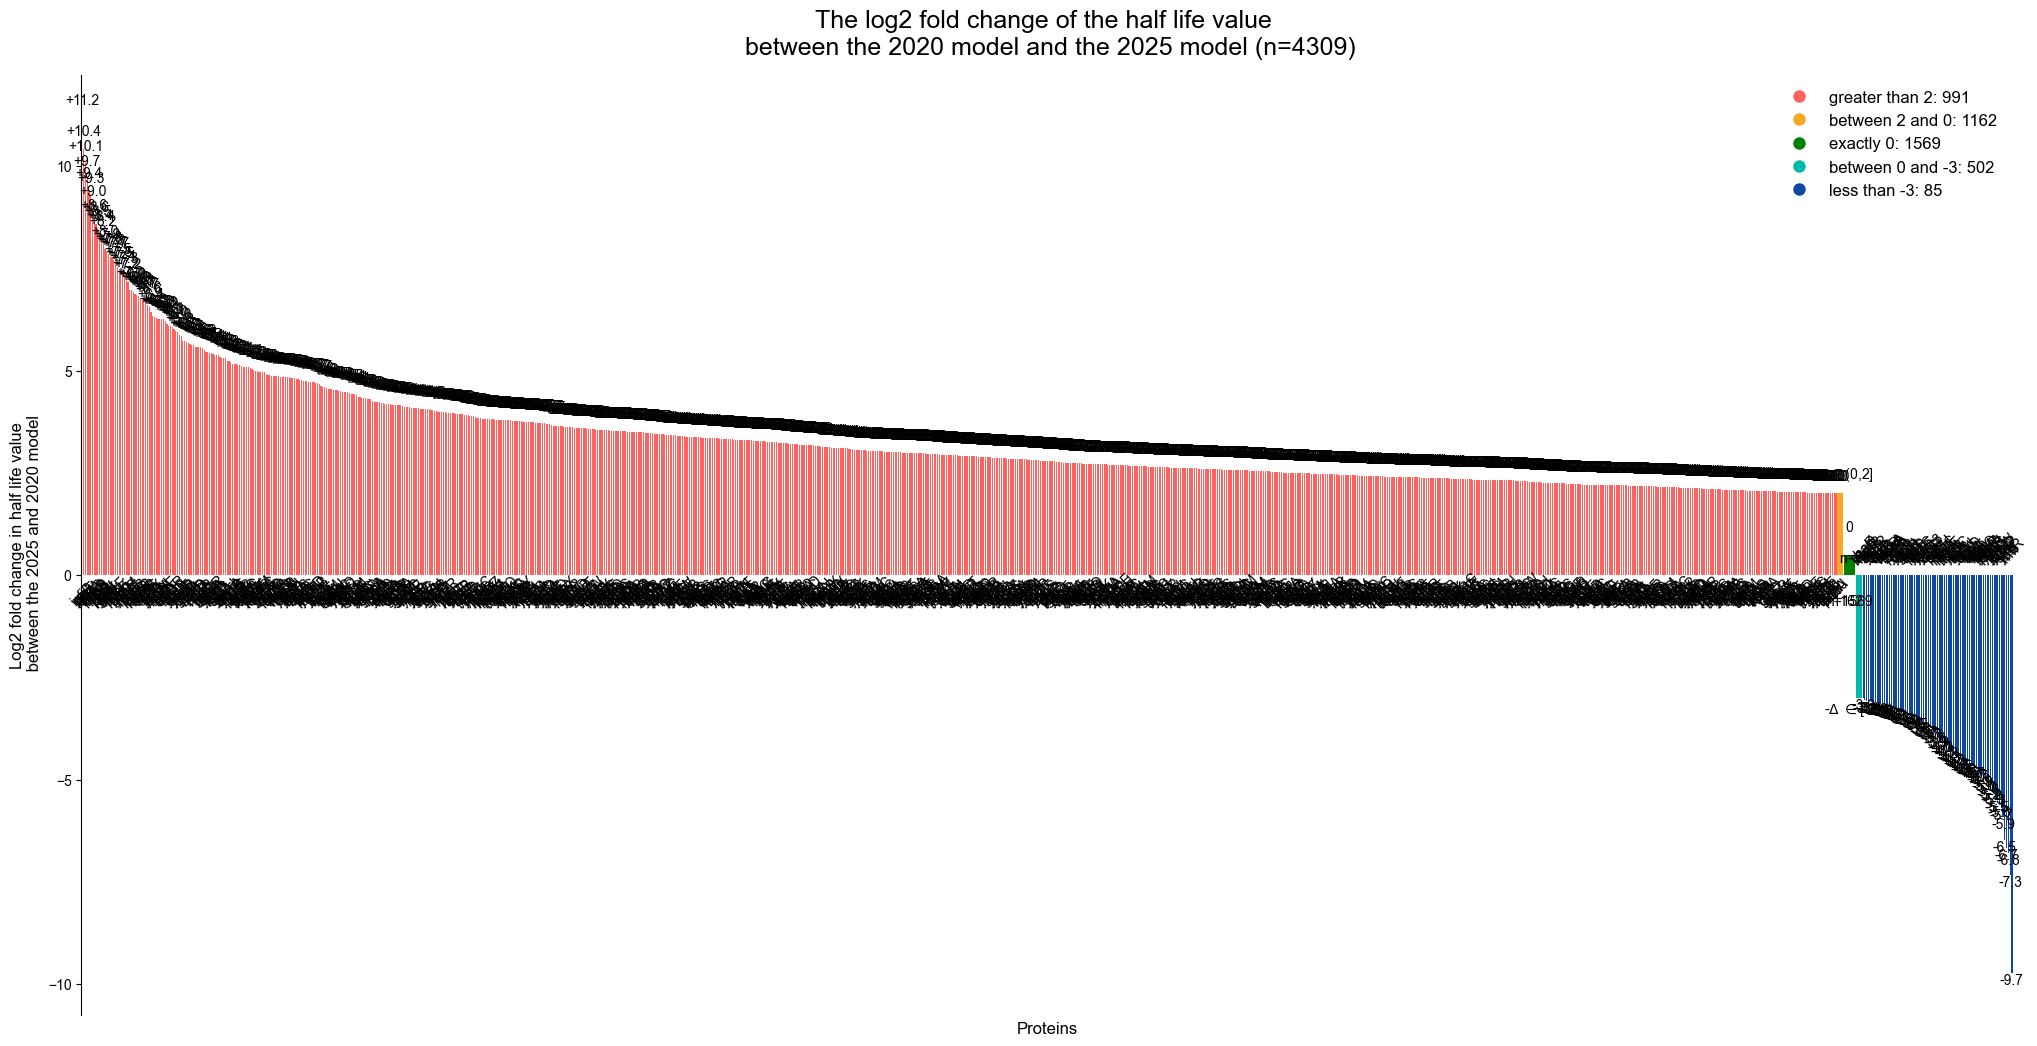

In [4]:
# define the data to use: 
df = combined_df.copy()

# define column to plot: 
column = 'HL_log2_fold_change'

# define bounds for changes
upper = 2
middle = 0
lower = -3

# define the name of the file: 
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_histograms/log2_fold_change_in_HL_values_with_all_proteins_[{lower},{middle},{upper}]_{current_sequence}_{CLNE_sequence}.png"

# define the title of the plot:
title0 = f'The log2 fold change of the half life value \n between the 2020 model and the 2025 model (n={df.shape[0]})'

# find all of the half lives that are greater than 800:
CLClim3NE1_HLs_Clim3_above_upper = df[df[column] > upper] # 
CLClim3NE1_HLs_Clim3_above_upper = CLClim3NE1_HLs_Clim3_above_upper.copy()
CLClim3NE1_HLs_Clim3_above_upper["sort_color"] = "red"
CLClim3NE1_HLs_Clim3_above_upper["column_width"] = "1"
words_u = f'greater than {upper}: {CLClim3NE1_HLs_Clim3_above_upper.shape[0]}'
print(words_u)

# find all the half lives between 800 and 0: 
CLClim3NE1_HLs_Clim3_upper_to_zero = df[(df[column] <= upper) & (df[column] > middle)] # 
CLClim3NE1_HLs_Clim3_upper_to_zero = CLClim3NE1_HLs_Clim3_upper_to_zero.copy()
CLClim3NE1_HLs_Clim3_upper_to_zero["sort_color"] = "orange"
CLClim3NE1_HLs_Clim3_upper_to_zero["column_width"] = "4"
words_u2m = f'between {upper} and {middle}: {CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}'
print(words_u2m)

CLClim3NE1_HLs_Clim3_middle = df[df[column] == middle ] #
CLClim3NE1_HLs_Clim3_middle = CLClim3NE1_HLs_Clim3_middle.copy()
CLClim3NE1_HLs_Clim3_middle["sort_color"] = "green"
CLClim3NE1_HLs_Clim3_middle["column_width"] = "4"
words_m = f'exactly {middle}: {CLClim3NE1_HLs_Clim3_middle.shape[0]}'
print(words_m)

# find all half lives between 600 and 200: 
CLClim3NE1_HLs_Clim3_0_to_lower = df[(df[column] < middle) & (df[column] > lower)] # 
CLClim3NE1_HLs_Clim3_0_to_lower = CLClim3NE1_HLs_Clim3_0_to_lower.copy()
CLClim3NE1_HLs_Clim3_0_to_lower["sort_color"] = "lightblue"
CLClim3NE1_HLs_Clim3_0_to_lower["column_width"] = "4"
words_m2l = f'between {middle} and {lower}: {CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}'
print(words_m2l)

# find all the half lives between 200 and 0:
CLClim3NE1_HLs_Clim3_lower = df[(df[column] <= lower)] # 
CLClim3NE1_HLs_Clim3_lower = CLClim3NE1_HLs_Clim3_lower.copy()
CLClim3NE1_HLs_Clim3_lower["sort_color"] = "blue"
CLClim3NE1_HLs_Clim3_lower["column_width"] = "1"
words_l = f'less than {lower}: {CLClim3NE1_HLs_Clim3_lower.shape[0]}'
print(words_l)


# make a new data frame that is more simple
# concatenate the data frames together:
CLClim3NE1_HLs_Clim3_split_protein_difference = pd.concat([CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_lower], ignore_index=True)
data = CLClim3NE1_HLs_Clim3_split_protein_difference[['common_name', column,'sort_color', 'column_width']]

# add a new rows to the data: 
new_rows = [
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}',
        column: upper,
        'sort_color': 'orange',
        'column_width': 4
    },
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_middle.shape[0]}',
        column: middle + 0.5,
        'sort_color': 'green',
        'column_width': 4
    },
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}',
        column: lower,
        'sort_color': 'lightblue',
        'column_width': 4
    }
]

# convert new rows to a DataFrame:
new_rows_df = pd.DataFrame(new_rows)
data = pd.concat([data, new_rows_df], ignore_index=True)

# sort the data
data = data.sort_values(by=[column], ascending=False)
data.set_index('common_name', inplace=True)


# create a color dictionary for the colors:
color_dict = {'red': '#fd625e', 'orange': '#f9a825', 'green': 'green', 'lightblue': '#01b8aa', 'blue': '#0d47a1'}

# create a size dictionary for the sizes:
size_dict = {'red': .1, 'orange': .5, 'green':1,'lightblue': .5, 'blue': .1}

upper_len = int(CLClim3NE1_HLs_Clim3_above_upper.shape[0])
lower_len = int(CLClim3NE1_HLs_Clim3_lower.shape[0])

first_ticks = np.ones(upper_len) * size_dict['red']
second_ticks = np.ones(1) * size_dict['orange']
third_ticks = np.ones(1) * size_dict['green']
fourth_ticks = np.ones(1) * size_dict['lightblue']
fifth_ticks = np.ones(lower_len) * size_dict['blue']
col_widths = [first_ticks, second_ticks, third_ticks, fourth_ticks, fifth_ticks]
col_widths = np.concatenate(col_widths)
col_widths

# GET THE POSITIONS OF THE BARS
# from: https://stackoverflow.com/questions/70477458/how-can-i-plot-bar-plots-with-variable-widths-but-without-gaps-in-python-and-ad
a = 0
x_positions = []
for i in range(len(col_widths)):
    if i == 0:
        a+=col_widths[i]
       
        x_positions.append(col_widths[i]/2)
        
    else:
        a += col_widths[i] + 0.05 # adding a gap 
       
        x_positions.append(a - col_widths[i]/2)

x_positions = np.array(x_positions)

# MAKE THE PLOT
# using this: https://sharkcoder.com/data-visualization/mpl-bidirectional
font_color = '#525252'
hfont = {'fontname':'Calibri'}
color_red = '#fd625e'
color_blue = '#01b8aa'
index = data.index
column0 = data[column]

fig, axes = plt.subplots(figsize=(20,10),  nrows=1)
fig.tight_layout()

#axes.bar(index, column0, align='center', color=color_red, zorder=10)
axes.set_title(title0, fontsize=18, pad=15, )


ticks_to_plot = []
for i, val in enumerate(column0):
    axes.bar(x_positions[i], val, color=color_dict[data['sort_color'].iloc[i]], width=size_dict[data['sort_color'].iloc[i]])
    if data['sort_color'].iloc[i] == 'red':
        axes.text(x_positions[i], val + 0.25, f"+{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
    if data['sort_color'].iloc[i] == 'blue':
        axes.text(x_positions[i], val - 0.35, f"{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
    if data['sort_color'].iloc[i] == 'green':
        axes.text(x_positions[i], val + 0.5, f"{middle}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
    if data['sort_color'].iloc[i] == 'orange':
        axes.text(x_positions[i], val + 0.25, f"+$\\Delta$ $\\in$({middle},{upper}]", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
    if data['sort_color'].iloc[i] == 'lightblue':
        axes.text(x_positions[i], val - .5, f"-$\\Delta$ $\\in$[{lower},{middle})", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )



axes.set_ylabel('Log2 fold change in half life value\n between the 2025 and 2020 model', fontsize=12, color="black", )
axes.set_xlabel('Proteins', fontsize=12, color="black", )
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_visible(False)
axes.set_xticks([])
axes.margins(x=0.0)

#axes.set_ylim(-600, (lower + 2))  # cant do this here, should only do it when I do not have a shared x axis! 

# add a legend: 
#axes.legend(loc='upper right', fontsize=12, frameon=False, markerscale=2)
axes.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label=words_u, markerfacecolor=color_dict['red'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_u2m, markerfacecolor=color_dict['orange'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_m, markerfacecolor=color_dict['green'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_m2l, markerfacecolor=color_dict['lightblue'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_l, markerfacecolor=color_dict['blue'], markersize=5)
    ],
    loc='upper right',
    fontsize=12,
    frameon=False,
    markerscale=2
)   

# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')


# Generate the log2 fold change protein count bar plot


greater than 4: 24
between 4 and 0: 1755
exactly 0: 149
between 0 and -4: 2327
less than -4: 54


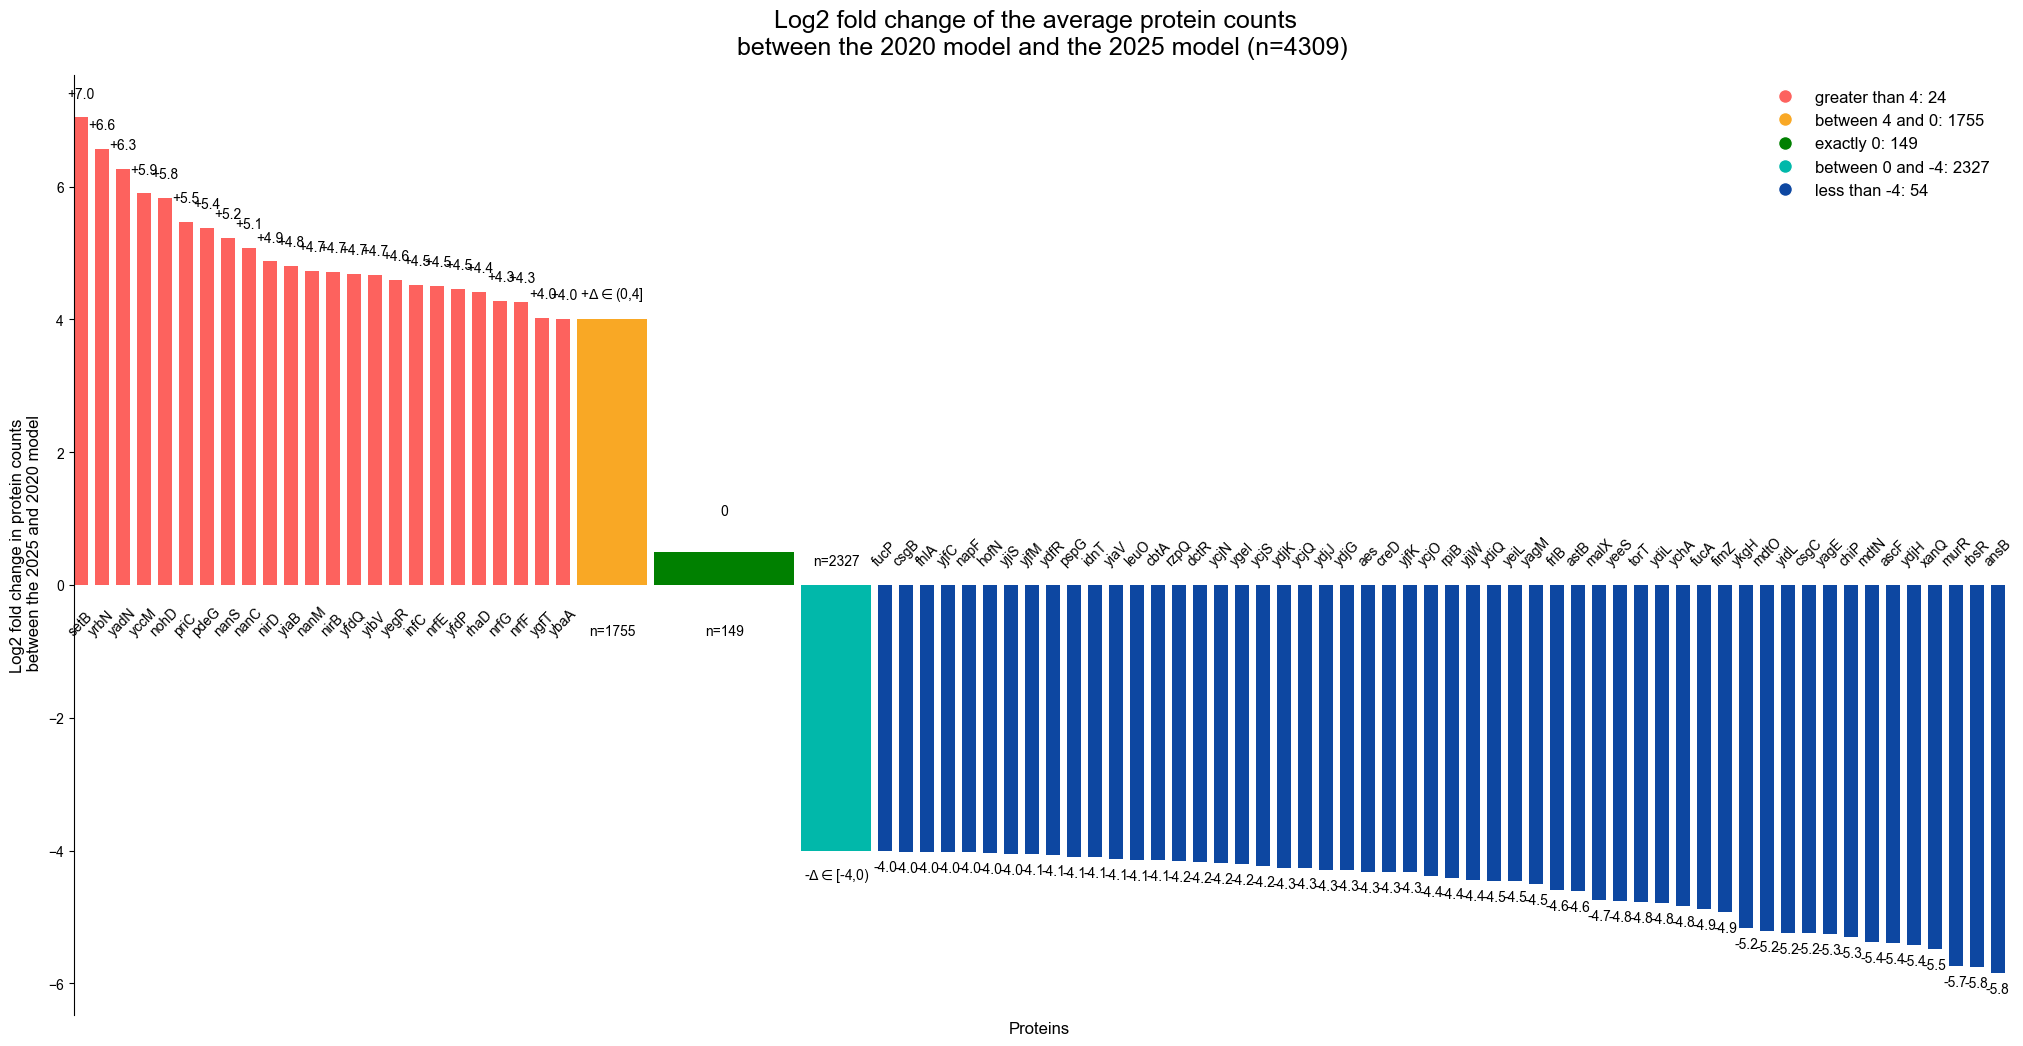

In [5]:
# define the data to use: 
df = combined_df.copy()

# define column to plot: 
column = 'PC_log2_fold_change'

# define bounds for changes
upper = 4
middle = 0
lower = -4

# define the name of the file: 
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_histograms/log2_fold_change_in_protein_count_values_with_all_proteins_[{lower},{middle},{upper}]_{current_sequence}_{CLNE_sequence}.png"

# define the title of the plot:
title0 = f'Log2 fold change of the average protein counts \n between the 2020 model and the 2025 model (n={df.shape[0]})'

# find all of the half lives that are greater than 800:
CLClim3NE1_HLs_Clim3_above_upper = df[df[column] > upper] # 
CLClim3NE1_HLs_Clim3_above_upper = CLClim3NE1_HLs_Clim3_above_upper.copy()
CLClim3NE1_HLs_Clim3_above_upper["sort_color"] = "red"
CLClim3NE1_HLs_Clim3_above_upper["column_width"] = "1"
words_u = f'greater than {upper}: {CLClim3NE1_HLs_Clim3_above_upper.shape[0]}'
print(words_u)

# find all the half lives between 800 and 0: 
CLClim3NE1_HLs_Clim3_upper_to_zero = df[(df[column] <= upper) & (df[column] > middle)] # 
CLClim3NE1_HLs_Clim3_upper_to_zero = CLClim3NE1_HLs_Clim3_upper_to_zero.copy()
CLClim3NE1_HLs_Clim3_upper_to_zero["sort_color"] = "orange"
CLClim3NE1_HLs_Clim3_upper_to_zero["column_width"] = "4"
words_u2m = f'between {upper} and {middle}: {CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}'
print(words_u2m)

CLClim3NE1_HLs_Clim3_middle = df[df[column] == middle ] #
CLClim3NE1_HLs_Clim3_middle = CLClim3NE1_HLs_Clim3_middle.copy()
CLClim3NE1_HLs_Clim3_middle["sort_color"] = "green"
CLClim3NE1_HLs_Clim3_middle["column_width"] = "4"
words_m = f'exactly {middle}: {CLClim3NE1_HLs_Clim3_middle.shape[0]}'
print(words_m)

# find all half lives between 600 and 200: 
CLClim3NE1_HLs_Clim3_0_to_lower = df[(df[column] < middle) & (df[column] > lower)] # 
CLClim3NE1_HLs_Clim3_0_to_lower = CLClim3NE1_HLs_Clim3_0_to_lower.copy()
CLClim3NE1_HLs_Clim3_0_to_lower["sort_color"] = "lightblue"
CLClim3NE1_HLs_Clim3_0_to_lower["column_width"] = "4"
words_m2l = f'between {middle} and {lower}: {CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}'
print(words_m2l)

# find all the half lives between 200 and 0:
CLClim3NE1_HLs_Clim3_lower = df[(df[column] <= lower)] # 
CLClim3NE1_HLs_Clim3_lower = CLClim3NE1_HLs_Clim3_lower.copy()
CLClim3NE1_HLs_Clim3_lower["sort_color"] = "blue"
CLClim3NE1_HLs_Clim3_lower["column_width"] = "1"
words_l = f'less than {lower}: {CLClim3NE1_HLs_Clim3_lower.shape[0]}'
print(words_l)


# make a new data frame that is more simple
# concatenate the data frames together:
CLClim3NE1_HLs_Clim3_split_protein_difference = pd.concat([CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_lower], ignore_index=True)
data = CLClim3NE1_HLs_Clim3_split_protein_difference[['common_name', column,'sort_color', 'column_width']]

# add a new rows to the data: 
new_rows = [
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}',
        column: upper,
        'sort_color': 'orange',
        'column_width': 4
    },
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_middle.shape[0]}',
        column: middle + 0.5,
        'sort_color': 'green',
        'column_width': 4
    },
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}',
        column: lower,
        'sort_color': 'lightblue',
        'column_width': 4
    }
]

# convert new rows to a DataFrame:
new_rows_df = pd.DataFrame(new_rows)
data = pd.concat([data, new_rows_df], ignore_index=True)

# sort the data
data = data.sort_values(by=[column], ascending=False)
data.set_index('common_name', inplace=True)


# create a color dictionary for the colors:
color_dict = {'red': '#fd625e', 'orange': '#f9a825', 'green': 'green', 'lightblue': '#01b8aa', 'blue': '#0d47a1'}

# create a size dictionary for the sizes:
size_dict = {'red': .1, 'orange': .5, 'green':1,'lightblue': .5, 'blue': .1}

upper_len = int(CLClim3NE1_HLs_Clim3_above_upper.shape[0])
lower_len = int(CLClim3NE1_HLs_Clim3_lower.shape[0])

first_ticks = np.ones(upper_len) * size_dict['red']
second_ticks = np.ones(1) * size_dict['orange']
third_ticks = np.ones(1) * size_dict['green']
fourth_ticks = np.ones(1) * size_dict['lightblue']
fifth_ticks = np.ones(lower_len) * size_dict['blue']
col_widths = [first_ticks, second_ticks, third_ticks, fourth_ticks, fifth_ticks]
col_widths = np.concatenate(col_widths)
col_widths

# GET THE POSITIONS OF THE BARS
# from: https://stackoverflow.com/questions/70477458/how-can-i-plot-bar-plots-with-variable-widths-but-without-gaps-in-python-and-ad
a = 0
x_positions = []
for i in range(len(col_widths)):
    if i == 0:
        a+=col_widths[i]
       
        x_positions.append(col_widths[i]/2)
        
    else:
        a += col_widths[i] + 0.05 # adding a gap 
       
        x_positions.append(a - col_widths[i]/2)

x_positions = np.array(x_positions)

# MAKE THE PLOT
# using this: https://sharkcoder.com/data-visualization/mpl-bidirectional
font_color = '#525252'
hfont = {'fontname':'Calibri'}
color_red = '#fd625e'
color_blue = '#01b8aa'
index = data.index
column0 = data[column]

fig, axes = plt.subplots(figsize=(20,10),  nrows=1)
fig.tight_layout()

#axes.bar(index, column0, align='center', color=color_red, zorder=10)
axes.set_title(title0, fontsize=18, pad=15, )


ticks_to_plot = []
for i, val in enumerate(column0):
    axes.bar(x_positions[i], val, color=color_dict[data['sort_color'].iloc[i]], width=size_dict[data['sort_color'].iloc[i]])
    if data['sort_color'].iloc[i] == 'red':
        axes.text(x_positions[i], val + 0.25, f"+{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
    if data['sort_color'].iloc[i] == 'blue':
        axes.text(x_positions[i], val - 0.35, f"{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
    if data['sort_color'].iloc[i] == 'green':
        axes.text(x_positions[i], val + 0.5, f"{middle}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
    if data['sort_color'].iloc[i] == 'orange':
        axes.text(x_positions[i], val + 0.25, f"+$\\Delta$$\\in$({middle},{upper}]", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
    if data['sort_color'].iloc[i] == 'lightblue':
        axes.text(x_positions[i], val - .5, f"-$\\Delta$$\\in$[{lower},{middle})", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )



axes.set_ylabel('Log2 fold change in protein counts\n between the 2025 and 2020 model', fontsize=12, color="black", )
axes.set_xlabel('Proteins', fontsize=12, color="black", )
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_visible(False)
axes.set_xticks([])
axes.margins(x=0.0)

#axes.set_ylim(-600, (lower + 2))  # cant do this here, should only do it when I do not have a shared x axis! 

# add a legend: 
#axes.legend(loc='upper right', fontsize=12, frameon=False, markerscale=2)
axes.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label=words_u, markerfacecolor=color_dict['red'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_u2m, markerfacecolor=color_dict['orange'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_m, markerfacecolor=color_dict['green'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_m2l, markerfacecolor=color_dict['lightblue'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_l, markerfacecolor=color_dict['blue'], markersize=5)
    ],
    loc='upper right',
    fontsize=12,
    frameon=False,
    markerscale=2
)   

# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')


## Plot the log2 fold change of the protein counts using only the proteins that had a change in half life from their original value
prep the data first:

In [6]:
combined_df_of_proteins_with_new_HLs = combined_df.copy()

# remove the proteins that have a different half life value between new_half_life and original_half_life:
combined_df_of_proteins_with_new_HLs = combined_df_of_proteins_with_new_HLs[combined_df_of_proteins_with_new_HLs['HL_difference'] != 0] # should add up to 2675, as I believe that is how many were reassigned to Gupta et al. 2024 data! 

combined_df_of_proteins_with_new_HLs

,monomer_id,new_half_life,original_half_life,common_name,Log10 CLNE3 Average Monomer Counts,Log10 Clim4_annotated Average Monomer Counts,HL_difference,HL_fold_change,HL_log2_fold_change,PC_difference,PC_fold_change,PC_log2_fold_change,counts_new_+10,counts_old_+10,log2_counts_10,Log10 Validation Data Average Monomer Counts
1,1-PFK-MONOMER,15388.112655,600.0,fruK,1.829031,2.516061,14788.112655,25.646854,4.680710,260.684050,4.864409,2.282264,2.527813,1.883421,0.424534,1.755875
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,432.820802,600.0,panE,2.155309,2.336496,-167.179198,0.721368,-0.471193,74.026947,1.517704,0.601890,2.354143,2.181818,0.109671,1.414973
3,2-ISOPROPYLMALATESYN-MONOMER,545.536619,600.0,leuA,3.603593,3.587158,-54.463381,0.909228,-0.137286,-149.070303,0.962864,-0.054596,3.588168,3.604565,-0.006578,3.43329
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,1343.256864,600.0,ubiE,2.619919,2.215084,743.256864,2.238761,1.162701,-252.701409,0.393699,-1.344835,2.238273,2.629197,-0.232236,2.968483
5,2-OCTAPRENYLPHENOL-HYDROX-MONOMER,1785.916076,600.0,ubiB,1.791572,1.392446,1185.916076,2.976527,1.573630,-37.197302,0.398910,-1.325866,1.527446,1.850542,-0.276827,0.60206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4303,YTFQ-MONOMER,17033.143362,600.0,ytfQ,1.641263,0.845098,16433.143362,28.388572,4.827238,-36.778740,0.159895,-2.644804,1.204120,1.722459,-0.516491,2.0
4304,YTFR-MONOMER,2708.165245,600.0,ytfR,1.591232,0.778151,2108.165245,4.513609,2.174281,-33.015041,0.153787,-2.700996,1.176091,1.681377,-0.515643,0.0
4305,YTFT-MONOMER,2083.445324,600.0,ytfT,1.569764,0.954243,1483.445324,3.472409,1.795937,-28.133306,0.242370,-2.044717,1.255273,1.664015,-0.406667,None
4306,ZNUA-MONOMER,2225.002167,600.0,znuA,2.792515,2.988847,1625.002167,3.708337,1.890772,354.468993,1.571561,0.652199,2.992839,2.798773,0.096720,2.638489


greater than 3: 35
between 3 and 0: 1241
exactly 0: 4
between 0 and -3: 1376
less than -3: 84


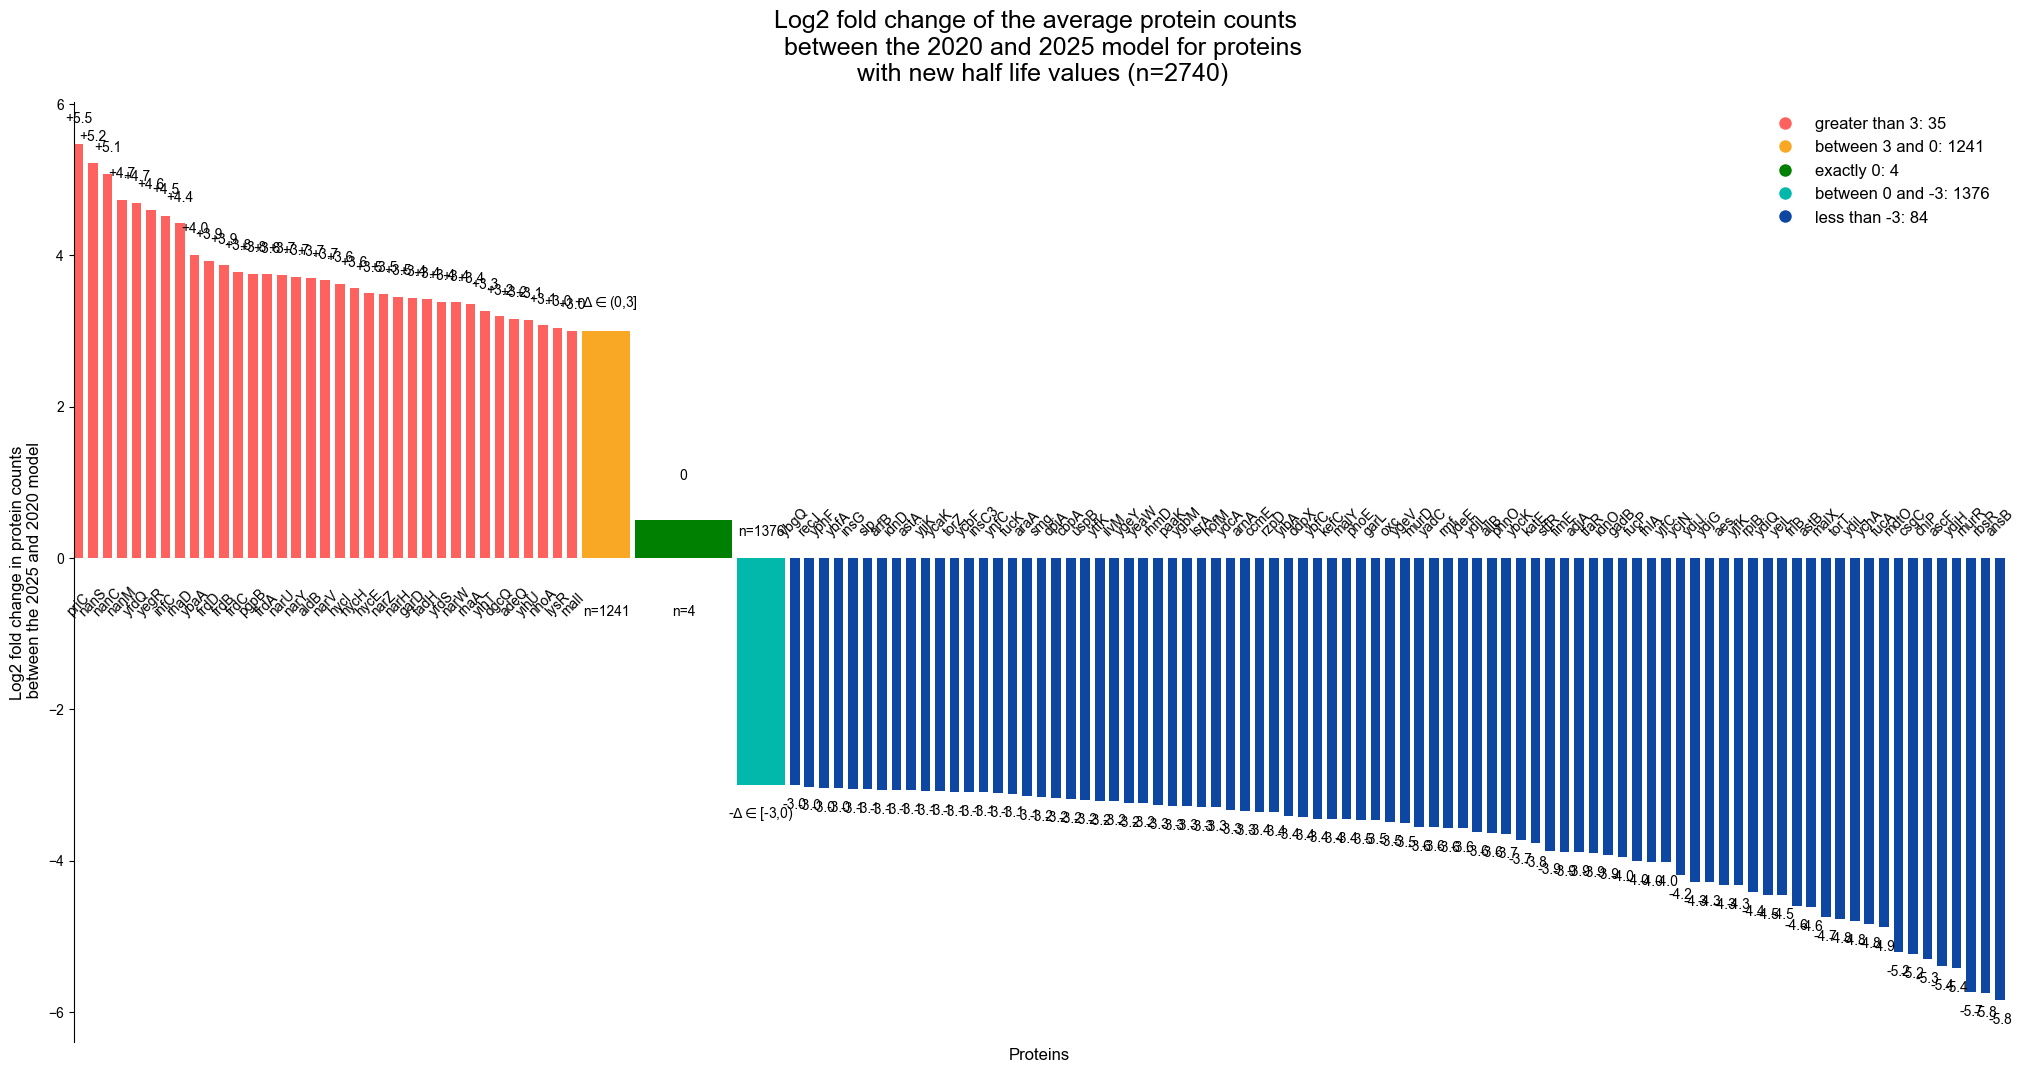

In [7]:
# define the dataframe to plot: 
df = combined_df_of_proteins_with_new_HLs.copy()

# define column to plot: 
column = 'PC_log2_fold_change'

# define bounds for changes
upper = 3
middle = 0
lower = -3

# define the name of the file: 
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_histograms/log2_fold_change_in_protein_count_values_for_proteins_with_new_HL_values_bounds[{lower},{middle},{upper}]_{current_sequence}_{CLNE_sequence}.png"

# define the title of the plot:
title0 = f'Log2 fold change of the average protein counts \n between the 2020 and 2025 model for proteins\n with new half life values (n={df.shape[0]})'


# find all of the half lives that are greater than 800:
CLClim3NE1_HLs_Clim3_above_upper = df[df[column] > upper] # 
CLClim3NE1_HLs_Clim3_above_upper = CLClim3NE1_HLs_Clim3_above_upper.copy()
CLClim3NE1_HLs_Clim3_above_upper["sort_color"] = "red"
CLClim3NE1_HLs_Clim3_above_upper["column_width"] = "1"
words_u = f'greater than {upper}: {CLClim3NE1_HLs_Clim3_above_upper.shape[0]}'
print(words_u)

# find all the half lives between 800 and 0: 
CLClim3NE1_HLs_Clim3_upper_to_zero = df[(df[column] <= upper) & (df[column] > middle)] # 
CLClim3NE1_HLs_Clim3_upper_to_zero = CLClim3NE1_HLs_Clim3_upper_to_zero.copy()
CLClim3NE1_HLs_Clim3_upper_to_zero["sort_color"] = "orange"
CLClim3NE1_HLs_Clim3_upper_to_zero["column_width"] = "4"
words_u2m = f'between {upper} and {middle}: {CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}'
print(words_u2m)

CLClim3NE1_HLs_Clim3_middle = df[df[column] == middle ] #
CLClim3NE1_HLs_Clim3_middle = CLClim3NE1_HLs_Clim3_middle.copy()
CLClim3NE1_HLs_Clim3_middle["sort_color"] = "green"
CLClim3NE1_HLs_Clim3_middle["column_width"] = "4"
words_m = f'exactly {middle}: {CLClim3NE1_HLs_Clim3_middle.shape[0]}'
print(words_m)

# find all half lives between 600 and 200: 
CLClim3NE1_HLs_Clim3_0_to_lower = df[(df[column] < middle) & (df[column] > lower)] # 
CLClim3NE1_HLs_Clim3_0_to_lower = CLClim3NE1_HLs_Clim3_0_to_lower.copy()
CLClim3NE1_HLs_Clim3_0_to_lower["sort_color"] = "lightblue"
CLClim3NE1_HLs_Clim3_0_to_lower["column_width"] = "4"
words_m2l = f'between {middle} and {lower}: {CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}'
print(words_m2l)

# find all the half lives between 200 and 0:
CLClim3NE1_HLs_Clim3_lower = df[(df[column] <= lower)] # 
CLClim3NE1_HLs_Clim3_lower = CLClim3NE1_HLs_Clim3_lower.copy()
CLClim3NE1_HLs_Clim3_lower["sort_color"] = "blue"
CLClim3NE1_HLs_Clim3_lower["column_width"] = "1"
words_l = f'less than {lower}: {CLClim3NE1_HLs_Clim3_lower.shape[0]}'
print(words_l)


# make a new data frame that is more simple
# concatenate the data frames together:
CLClim3NE1_HLs_Clim3_split_protein_difference = pd.concat([CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_lower], ignore_index=True)
data = CLClim3NE1_HLs_Clim3_split_protein_difference[['common_name', column,'sort_color', 'column_width']]

# add a new rows to the data: 
new_rows = [
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}',
        column: upper,
        'sort_color': 'orange',
        'column_width': 4
    },
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_middle.shape[0]}',
        column: middle + 0.5,
        'sort_color': 'green',
        'column_width': 4
    },
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}',
        column: lower,
        'sort_color': 'lightblue',
        'column_width': 4
    }
]

# convert new rows to a DataFrame:
new_rows_df = pd.DataFrame(new_rows)
data = pd.concat([data, new_rows_df], ignore_index=True)

# sort the data
data = data.sort_values(by=[column], ascending=False)
data.set_index('common_name', inplace=True)


# create a color dictionary for the colors:
color_dict = {'red': '#fd625e', 'orange': '#f9a825', 'green': 'green', 'lightblue': '#01b8aa', 'blue': '#0d47a1'}

# create a size dictionary for the sizes:
size_dict = {'red': .1, 'orange': .5, 'green':1,'lightblue': .5, 'blue': .1}

upper_len = int(CLClim3NE1_HLs_Clim3_above_upper.shape[0])
lower_len = int(CLClim3NE1_HLs_Clim3_lower.shape[0])

first_ticks = np.ones(upper_len) * size_dict['red']
second_ticks = np.ones(1) * size_dict['orange']
third_ticks = np.ones(1) * size_dict['green']
fourth_ticks = np.ones(1) * size_dict['lightblue']
fifth_ticks = np.ones(lower_len) * size_dict['blue']
col_widths = [first_ticks, second_ticks, third_ticks, fourth_ticks, fifth_ticks]
col_widths = np.concatenate(col_widths)
col_widths

# GET THE POSITIONS OF THE BARS
# from: https://stackoverflow.com/questions/70477458/how-can-i-plot-bar-plots-with-variable-widths-but-without-gaps-in-python-and-ad
a = 0
x_positions = []
for i in range(len(col_widths)):
    if i == 0:
        a+=col_widths[i]
       
        x_positions.append(col_widths[i]/2)
        
    else:
        a += col_widths[i] + 0.05 # adding a gap 
       
        x_positions.append(a - col_widths[i]/2)

x_positions = np.array(x_positions)

# MAKE THE PLOT
# using this: https://sharkcoder.com/data-visualization/mpl-bidirectional
font_color = '#525252'
hfont = {'fontname':'Calibri'}
color_red = '#fd625e'
color_blue = '#01b8aa'
index = data.index
column0 = data[column]

fig, axes = plt.subplots(figsize=(20,10),  nrows=1)
fig.tight_layout()

#axes.bar(index, column0, align='center', color=color_red, zorder=10)
axes.set_title(title0, fontsize=18, pad=15, )


ticks_to_plot = []
for i, val in enumerate(column0):
    axes.bar(x_positions[i], val, color=color_dict[data['sort_color'].iloc[i]], width=size_dict[data['sort_color'].iloc[i]])
    if data['sort_color'].iloc[i] == 'red':
        axes.text(x_positions[i], val + 0.25, f"+{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
    if data['sort_color'].iloc[i] == 'blue':
        axes.text(x_positions[i], val - 0.35, f"{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
    if data['sort_color'].iloc[i] == 'green':
        axes.text(x_positions[i], val + 0.5, f"{middle}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
    if data['sort_color'].iloc[i] == 'orange':
        axes.text(x_positions[i], val + 0.25, f"+$\\Delta$$\\in$({middle},{upper}]", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
    if data['sort_color'].iloc[i] == 'lightblue':
        axes.text(x_positions[i], val - .5, f"-$\\Delta$$\\in$[{lower},{middle})", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )



axes.set_ylabel('Log2 fold change in protein counts\n between the 2025 and 2020 model', fontsize=12, color="black", )
axes.set_xlabel('Proteins', fontsize=12, color="black", )
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_visible(False)
axes.set_xticks([])
axes.margins(x=0.0)

#axes.set_ylim(-600, (lower + 2))  # cant do this here, should only do it when I do not have a shared x axis! 

# add a legend: 
#axes.legend(loc='upper right', fontsize=12, frameon=False, markerscale=2)
axes.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label=words_u, markerfacecolor=color_dict['red'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_u2m, markerfacecolor=color_dict['orange'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_m, markerfacecolor=color_dict['green'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_m2l, markerfacecolor=color_dict['lightblue'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_l, markerfacecolor=color_dict['blue'], markersize=5)
    ],
    loc='upper right',
    fontsize=12,
    frameon=False,
    markerscale=2
)   



# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')


## Plot the log2 fold change of the protein counts using only the proteins that had no change in half life from their original value
Prep the data: 


In [8]:
combined_df_of_proteins_with_same_HLs = combined_df.copy()

# remove the proteins that have a different half life value between new_half_life and original_half_life:
combined_df_of_proteins_with_same_HLs = combined_df_of_proteins_with_same_HLs[combined_df_of_proteins_with_same_HLs['HL_difference'] == 0] # should add up to 2675, as I believe that is how many were reassigned to Gupta et al. 2024 data! 

combined_df_of_proteins_with_same_HLs


,monomer_id,new_half_life,original_half_life,common_name,Log10 CLNE3 Average Monomer Counts,Log10 Clim4_annotated Average Monomer Counts,HL_difference,HL_fold_change,HL_log2_fold_change,PC_difference,PC_fold_change,PC_log2_fold_change,counts_new_+10,counts_old_+10,log2_counts_10,Log10 Validation Data Average Monomer Counts
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,600.0,600.0,plsC,2.248895,2.170663,0.0,1.0,0.0,-29.239307,0.835156,-0.259882,2.196278,2.270390,-0.047880,1.643453
19,ABGT-MONOMER,600.0,600.0,abgT,0.496491,0.000000,0.0,1.0,0.0,-2.136827,0.318793,-1.649306,1.000000,1.084105,-0.116505,None
30,ACPSUB-MONOMER,600.0,600.0,citD,0.000000,0.301030,0.0,1.0,0.0,1.000000,2.000000,1.000000,1.041393,1.000000,0.058514,None
33,ACRF-MONOMER,600.0,600.0,acrF,0.000000,0.000000,0.0,1.0,0.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,None
51,AGAC-MONOMER,600.0,600.0,agaC,0.045585,0.301030,0.0,1.0,0.0,0.889330,1.800714,0.848569,1.041393,1.004780,0.051635,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4293,YNJC-MONOMER,600.0,600.0,ynjC,1.780245,1.495464,0.0,1.0,0.0,-28.995735,0.519062,-0.946022,1.605243,1.840670,-0.197440,None
4297,YPHD-MONOMER,600.0,600.0,yphD,1.153829,0.000000,0.0,1.0,0.0,-13.250479,0.070173,-3.832938,1.000000,1.366432,-0.450414,None
4300,YRBE-MONOMER,600.0,600.0,mlaE,2.291749,2.181459,0.0,1.0,0.0,-43.905733,0.775729,-0.366375,2.206463,2.311269,-0.066950,None
4302,YRBG-MONOMER,600.0,600.0,yrbG,1.438401,1.176091,0.0,1.0,0.0,-12.441063,0.546626,-0.871374,1.380211,1.561591,-0.178128,None


greater than 4: 15
between 4 and 0: 488
exactly 0: 145
between 0 and -4: 893
less than -4: 28


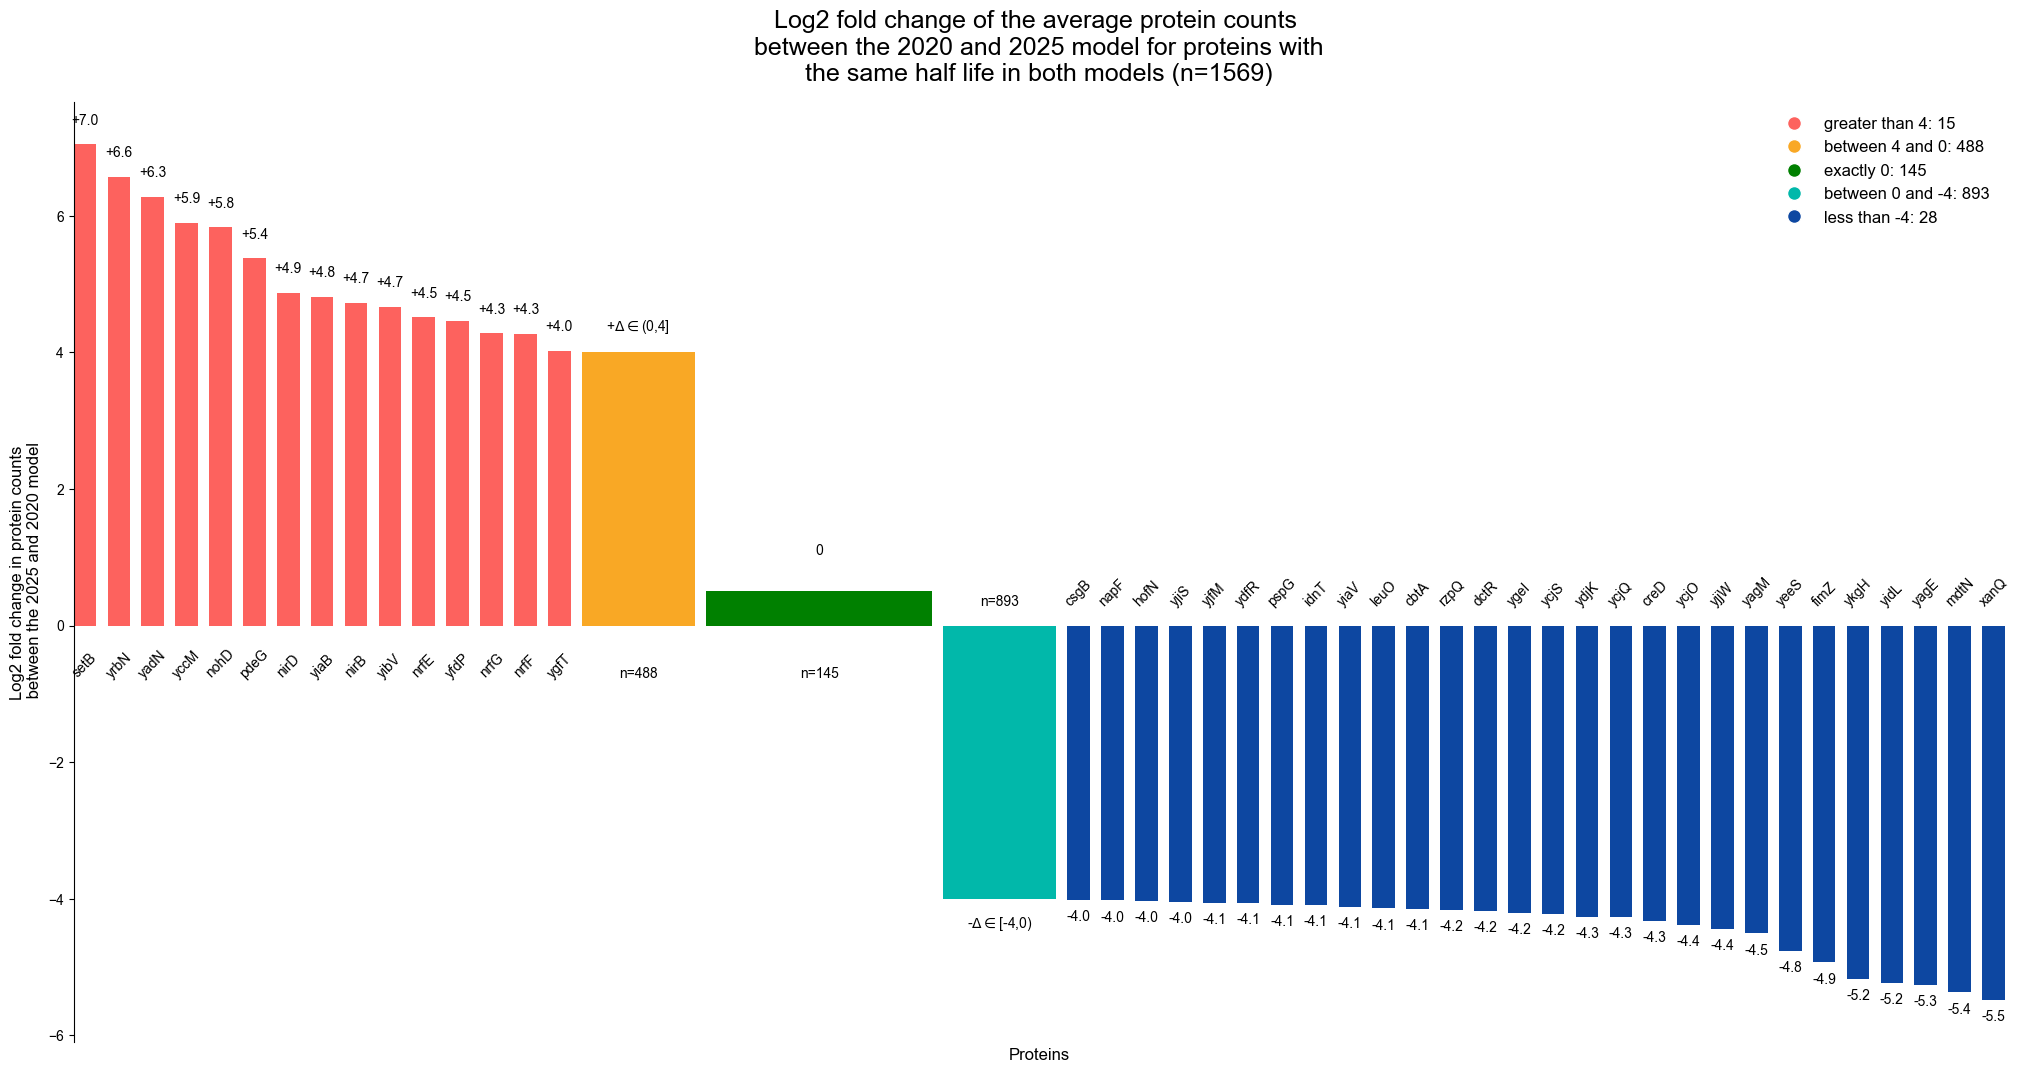

In [9]:
# define the data to use: 
df = combined_df_of_proteins_with_same_HLs.copy()

# define column to plot: 
column = 'PC_log2_fold_change'

# define bounds for changes
upper = 4
middle = 0
lower = -4

# define the name of the file: 
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_histograms/log2_fold_change_in_protein_count_values_for_proteins_with_no_change_in_HL_bounds[{lower},{middle},{upper}]_{current_sequence}_{CLNE_sequence}.png"

# define the title of the plot:
title0 = f'Log2 fold change of the average protein counts \n between the 2020 and 2025 model for proteins with \nthe same half life in both models (n={df.shape[0]})'

# find all of the half lives that are greater than 800:
CLClim3NE1_HLs_Clim3_above_upper = df[df[column] > upper] # 
CLClim3NE1_HLs_Clim3_above_upper = CLClim3NE1_HLs_Clim3_above_upper.copy()
CLClim3NE1_HLs_Clim3_above_upper["sort_color"] = "red"
CLClim3NE1_HLs_Clim3_above_upper["column_width"] = "1"
words_u = f'greater than {upper}: {CLClim3NE1_HLs_Clim3_above_upper.shape[0]}'
print(words_u)

# find all the half lives between 800 and 0: 
CLClim3NE1_HLs_Clim3_upper_to_zero = df[(df[column] <= upper) & (df[column] > middle)] # 
CLClim3NE1_HLs_Clim3_upper_to_zero = CLClim3NE1_HLs_Clim3_upper_to_zero.copy()
CLClim3NE1_HLs_Clim3_upper_to_zero["sort_color"] = "orange"
CLClim3NE1_HLs_Clim3_upper_to_zero["column_width"] = "4"
words_u2m = f'between {upper} and {middle}: {CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}'
print(words_u2m)

CLClim3NE1_HLs_Clim3_middle = df[df[column] == middle ] #
CLClim3NE1_HLs_Clim3_middle = CLClim3NE1_HLs_Clim3_middle.copy()
CLClim3NE1_HLs_Clim3_middle["sort_color"] = "green"
CLClim3NE1_HLs_Clim3_middle["column_width"] = "4"
words_m = f'exactly {middle}: {CLClim3NE1_HLs_Clim3_middle.shape[0]}'
print(words_m)

# find all half lives between 600 and 200: 
CLClim3NE1_HLs_Clim3_0_to_lower = df[(df[column] < middle) & (df[column] > lower)] # 
CLClim3NE1_HLs_Clim3_0_to_lower = CLClim3NE1_HLs_Clim3_0_to_lower.copy()
CLClim3NE1_HLs_Clim3_0_to_lower["sort_color"] = "lightblue"
CLClim3NE1_HLs_Clim3_0_to_lower["column_width"] = "4"
words_m2l = f'between {middle} and {lower}: {CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}'
print(words_m2l)

# find all the half lives between 200 and 0:
CLClim3NE1_HLs_Clim3_lower = df[(df[column] <= lower)] # 
CLClim3NE1_HLs_Clim3_lower = CLClim3NE1_HLs_Clim3_lower.copy()
CLClim3NE1_HLs_Clim3_lower["sort_color"] = "blue"
CLClim3NE1_HLs_Clim3_lower["column_width"] = "1"
words_l = f'less than {lower}: {CLClim3NE1_HLs_Clim3_lower.shape[0]}'
print(words_l)


# make a new data frame that is more simple
# concatenate the data frames together:
CLClim3NE1_HLs_Clim3_split_protein_difference = pd.concat([CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_lower], ignore_index=True)
data = CLClim3NE1_HLs_Clim3_split_protein_difference[['common_name', column,'sort_color', 'column_width']]

# add a new rows to the data: 
new_rows = [
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}',
        column: upper,
        'sort_color': 'orange',
        'column_width': 4
    },
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_middle.shape[0]}',
        column: middle + 0.5,
        'sort_color': 'green',
        'column_width': 4
    },
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}',
        column: lower,
        'sort_color': 'lightblue',
        'column_width': 4
    }
]

# convert new rows to a DataFrame:
new_rows_df = pd.DataFrame(new_rows)
data = pd.concat([data, new_rows_df], ignore_index=True)

# sort the data
data = data.sort_values(by=[column], ascending=False)
data.set_index('common_name', inplace=True)


# create a color dictionary for the colors:
color_dict = {'red': '#fd625e', 'orange': '#f9a825', 'green': 'green', 'lightblue': '#01b8aa', 'blue': '#0d47a1'}

# create a size dictionary for the sizes:
size_dict = {'red': .1, 'orange': .5, 'green':1,'lightblue': .5, 'blue': .1}

upper_len = int(CLClim3NE1_HLs_Clim3_above_upper.shape[0])
lower_len = int(CLClim3NE1_HLs_Clim3_lower.shape[0])

first_ticks = np.ones(upper_len) * size_dict['red']
second_ticks = np.ones(1) * size_dict['orange']
third_ticks = np.ones(1) * size_dict['green']
fourth_ticks = np.ones(1) * size_dict['lightblue']
fifth_ticks = np.ones(lower_len) * size_dict['blue']
col_widths = [first_ticks, second_ticks, third_ticks, fourth_ticks, fifth_ticks]
col_widths = np.concatenate(col_widths)
col_widths

# GET THE POSITIONS OF THE BARS
# from: https://stackoverflow.com/questions/70477458/how-can-i-plot-bar-plots-with-variable-widths-but-without-gaps-in-python-and-ad
a = 0
x_positions = []
for i in range(len(col_widths)):
    if i == 0:
        a+=col_widths[i]
       
        x_positions.append(col_widths[i]/2)
        
    else:
        a += col_widths[i] + 0.05 # adding a gap 
       
        x_positions.append(a - col_widths[i]/2)

x_positions = np.array(x_positions)

# MAKE THE PLOT
# using this: https://sharkcoder.com/data-visualization/mpl-bidirectional
font_color = '#525252'
hfont = {'fontname':'Calibri'}
color_red = '#fd625e'
color_blue = '#01b8aa'
index = data.index
column0 = data[column]

fig, axes = plt.subplots(figsize=(20,10),  nrows=1)
fig.tight_layout()

#axes.bar(index, column0, align='center', color=color_red, zorder=10)
axes.set_title(title0, fontsize=18, pad=15, )


ticks_to_plot = []
for i, val in enumerate(column0):
    axes.bar(x_positions[i], val, color=color_dict[data['sort_color'].iloc[i]], width=size_dict[data['sort_color'].iloc[i]])
    if data['sort_color'].iloc[i] == 'red':
        axes.text(x_positions[i], val + 0.25, f"+{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
    if data['sort_color'].iloc[i] == 'blue':
        axes.text(x_positions[i], val - 0.35, f"{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
    if data['sort_color'].iloc[i] == 'green':
        axes.text(x_positions[i], val + 0.5, f"{middle}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
    if data['sort_color'].iloc[i] == 'orange':
        axes.text(x_positions[i], val + 0.25, f"+$\\Delta$$\\in$({middle},{upper}]", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
    if data['sort_color'].iloc[i] == 'lightblue':
        axes.text(x_positions[i], val - .5, f"-$\\Delta$$\\in$[{lower},{middle})", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )



axes.set_ylabel('Log2 fold change in protein counts\n between the 2025 and 2020 model', fontsize=12, color="black", )
axes.set_xlabel('Proteins', fontsize=12, color="black", )
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_visible(False)
axes.set_xticks([])
axes.margins(x=0.0)

#axes.set_ylim(-600, (lower + 2))  # cant do this here, should only do it when I do not have a shared x axis! 

# add a legend: 
#axes.legend(loc='upper right', fontsize=12, frameon=False, markerscale=2)
axes.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label=words_u, markerfacecolor=color_dict['red'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_u2m, markerfacecolor=color_dict['orange'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_m, markerfacecolor=color_dict['green'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_m2l, markerfacecolor=color_dict['lightblue'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_l, markerfacecolor=color_dict['blue'], markersize=5)
    ],
    loc='upper right',
    fontsize=12,
    frameon=False,
    markerscale=2
)   



# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')


# Matrix of the changes

Specify what to plot:

In [17]:
# USER INPUTS:

# define bounds for changes in half lives:
HL_upper = 7
HL_middle = 0
HL_lower = -4

# define bounds for changes in protein counts:
PC_upper = 4
PC_middle = 0
PC_lower = -4

# define bounds for changes in the histogram
upper_histogram = None
lower_histogram = None
bins_histogram = 200

print("User inputs specified. now run the code in the next block!")

[0.05 0.2  0.35 0.5  0.65 0.8  0.95 1.1  1.25 1.4  1.55 1.7  1.85 2.
 2.15 2.5  3.3  4.1  4.45 4.6  4.75 4.9  5.05 5.2  5.35 5.5  5.65 5.8
 5.95 6.1  6.25 6.4  6.55 6.7  6.85 7.   7.15 7.3  7.45 7.6  7.75 7.9
 8.05 8.2  8.35 8.5 ]
HL_log2_fold_change
count    4309.000000
mean        0.855234
std         1.799465
min        -9.719653
25%         0.000000
50%         0.000000
75%         1.876595
max        11.192103
Name: HL_log2_fold_change, dtype: float64
greater than 7: 27
between 7 and 0: 2126
exactly 0: 1569
between 0 and -4: 545
less than -4: 42
PC_log2_fold_change
count    4309.000000
mean       -0.334431
std         1.399619
min        -5.838206
25%        -0.964097
50%        -0.102566
75%         0.341629
max         7.042992
Name: PC_log2_fold_change, dtype: float64
greater than 4: 24
between 4 and 0: 1755
exactly 0: 149
between 0 and -4: 2327
less than -4: 54
HL_log2_fold_change
count    4309.000000
mean        0.855234
std         1.799465
min        -9.719653
25%         0

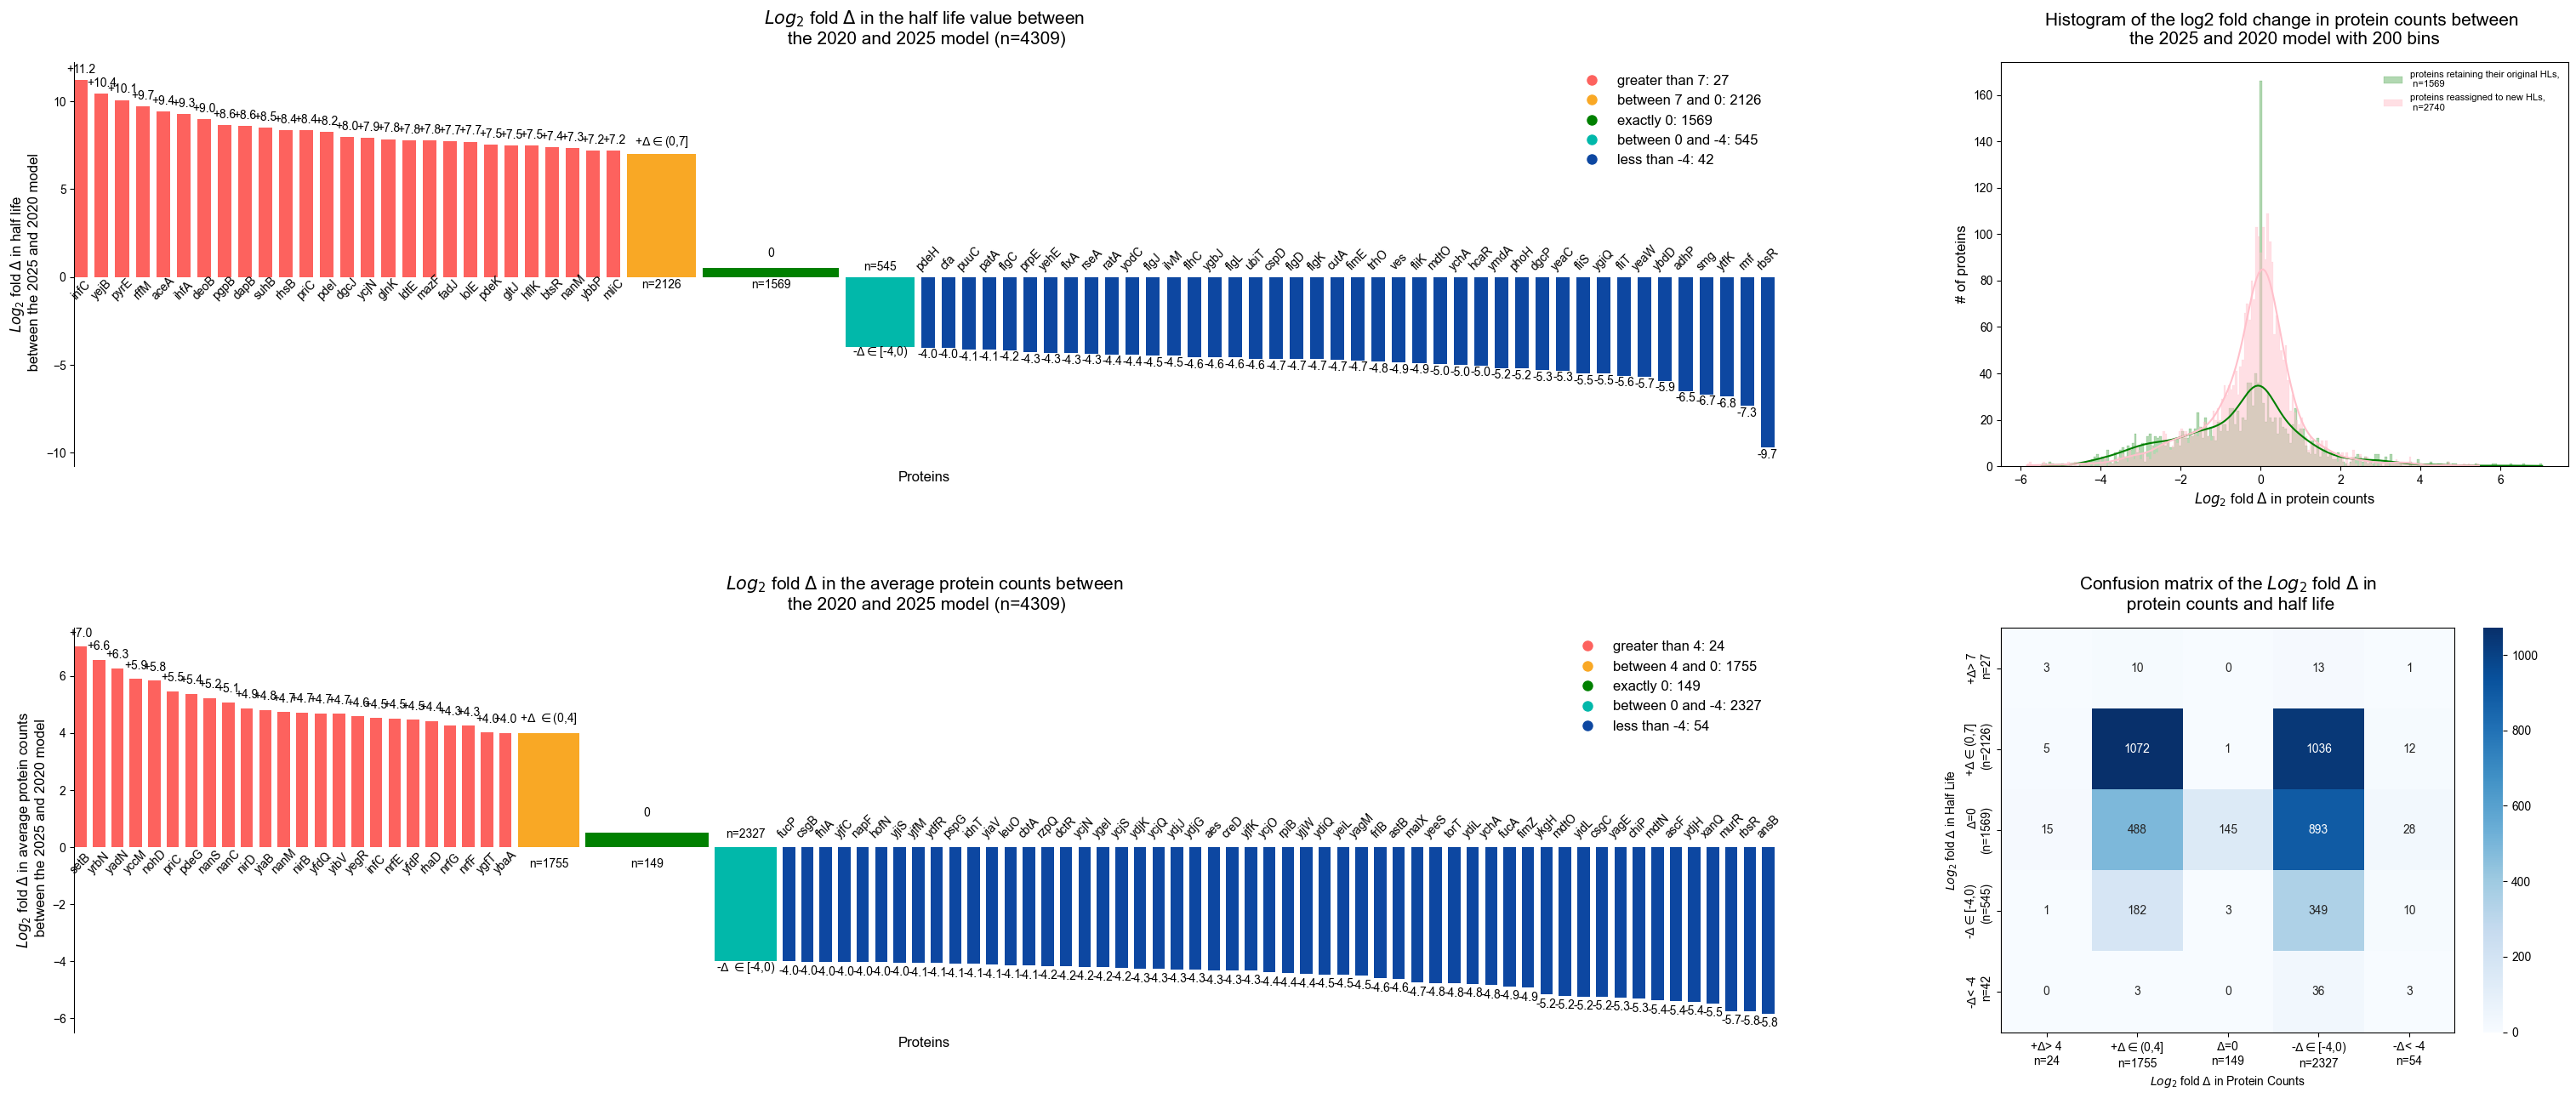

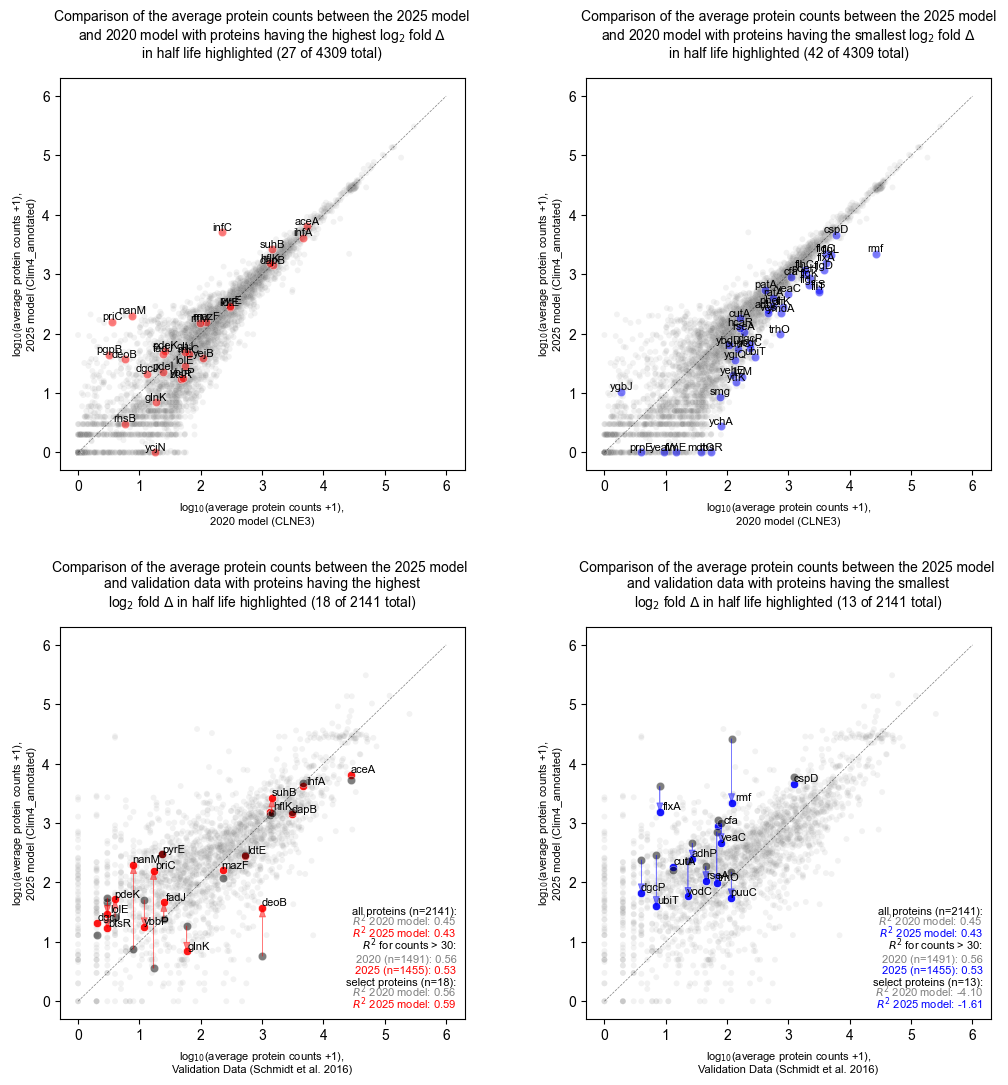

In [39]:

# todo: edit the functions to take in axes as an input (since it is currenlty not, which could cause issues later) 
# todo edit this to deal with inputs less than 1 since that messes up the order) 

# define the name of the file: 
out_pth_root = f"out/figures/{branch_name}/F2/matrix_plots/{current_sequence}_vs_{CLNE_sequence}/"
if not os.path.exists(out_pth_root):
    os.makedirs(out_pth_root)
    
# generate the first output file path:
specific_title1 = f"HL_matrix_HL_bounds[{HL_lower},{HL_middle},{HL_upper}]_PC_bounds[{PC_lower},{PC_middle},{PC_upper}]_histogram_xbounds[{upper_histogram},{lower_histogram}]_xbins[{bins_histogram}]_{current_sequence}_vs_{CLNE_sequence}.png"
out_pth_bar_graph = out_pth_root + specific_title1

specific_title2 = f"counts_validation_matrix_HL_bounds[{HL_lower},{HL_middle},{HL_upper}]_PC_bounds[{PC_lower},{PC_middle},{PC_upper}]_{current_sequence}_{CLNE_sequence}.png"
out_pth_validation_matrix = out_pth_root + specific_title2

# GENERATE THE BAR, HISTOGRAM, AND MATRIX PLOTS
# define the data to use: 
df = combined_df.copy()

# define columns to plot: 
column0 = 'HL_log2_fold_change'
column1 = 'PC_log2_fold_change'

# define column to plot in the histogram:
column_histogram = 'PC_log2_fold_change'

# define the title of the plot:
title0 = f'$Log_{2}$ fold $\\Delta$ in the half life value between\n the 2020 and 2025 model (n={df.shape[0]})'
title1 = f'$Log_{2}$ fold $\\Delta$ in the average protein counts between\n the 2020 and 2025 model (n={df.shape[0]})'


# END USER INPUTS
def r2_score_y_equals_x(y_true, y_pred):
    # Calculate the squared differences from the predicted line y=x
    residuals = y_true - y_pred
    ss_res = np.sum(residuals ** 2)  # Residual Sum of Squares

    # Calculate the total sum of squares
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)  # Total Sum of Squares

    # Calculate R²
    r2 = 1 - (ss_res / ss_tot)
    
    return r2


def obtain_data(df, column, upper, middle, lower):
    print(column)
    print(df[column].describe())
    # find all of the half lives that are greater than 800:
    CLClim3NE1_HLs_Clim3_above_upper = df[df[column] > upper] # 
    CLClim3NE1_HLs_Clim3_above_upper = CLClim3NE1_HLs_Clim3_above_upper.copy()
    CLClim3NE1_HLs_Clim3_above_upper["sort_color"] = "red"
    CLClim3NE1_HLs_Clim3_above_upper["column_width"] = "1"
    words_u = f'greater than {upper}: {CLClim3NE1_HLs_Clim3_above_upper.shape[0]}'
    print(words_u)
    
    # find all the half lives between 800 and 0: 
    CLClim3NE1_HLs_Clim3_upper_to_zero = df[(df[column] <= upper) & (df[column] > middle)] # 
    CLClim3NE1_HLs_Clim3_upper_to_zero = CLClim3NE1_HLs_Clim3_upper_to_zero.copy()
    CLClim3NE1_HLs_Clim3_upper_to_zero["sort_color"] = "orange"
    CLClim3NE1_HLs_Clim3_upper_to_zero["column_width"] = "4"
    words_u2m = f'between {upper} and {middle}: {CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}'
    print(words_u2m)
    
    CLClim3NE1_HLs_Clim3_middle = df[df[column] == middle ] #
    CLClim3NE1_HLs_Clim3_middle = CLClim3NE1_HLs_Clim3_middle.copy()
    CLClim3NE1_HLs_Clim3_middle["sort_color"] = "green"
    CLClim3NE1_HLs_Clim3_middle["column_width"] = "4"
    words_m = f'exactly {middle}: {CLClim3NE1_HLs_Clim3_middle.shape[0]}'
    print(words_m)
    
    # find all half lives between 600 and 200: 
    CLClim3NE1_HLs_Clim3_0_to_lower = df[(df[column] < middle) & (df[column] >= lower)] # 
    CLClim3NE1_HLs_Clim3_0_to_lower = CLClim3NE1_HLs_Clim3_0_to_lower.copy()
    CLClim3NE1_HLs_Clim3_0_to_lower["sort_color"] = "lightblue"
    CLClim3NE1_HLs_Clim3_0_to_lower["column_width"] = "4"
    words_m2l = f'between {middle} and {lower}: {CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}'
    print(words_m2l)
    
    # find all the half lives between 200 and 0:
    CLClim3NE1_HLs_Clim3_lower = df[(df[column] < lower)] # 
    CLClim3NE1_HLs_Clim3_lower = CLClim3NE1_HLs_Clim3_lower.copy()
    CLClim3NE1_HLs_Clim3_lower["sort_color"] = "blue"
    CLClim3NE1_HLs_Clim3_lower["column_width"] = "1"
    words_l = f'less than {lower}: {CLClim3NE1_HLs_Clim3_lower.shape[0]}'
    print(words_l)

    return(CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_upper_to_zero, CLClim3NE1_HLs_Clim3_middle, CLClim3NE1_HLs_Clim3_0_to_lower, CLClim3NE1_HLs_Clim3_lower, words_u, words_u2m, words_m, words_m2l, words_l)



def clean_data(column, CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_upper_to_zero, CLClim3NE1_HLs_Clim3_middle, CLClim3NE1_HLs_Clim3_0_to_lower, CLClim3NE1_HLs_Clim3_lower, upper, middle, lower):
    # make a new data frame that is more simple
    # concatenate the data frames together:
    CLClim3NE1_HLs_Clim3_split_protein_difference = pd.concat([CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_lower], ignore_index=True)
    data = CLClim3NE1_HLs_Clim3_split_protein_difference[['common_name', column,'sort_color', 'column_width']]
    
    # add a new rows to the data: 
    new_rows = [
        {
            'common_name': f'n={CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}',
            column: upper, 
            'sort_color': 'orange',
            'column_width': 4
        },
        {
            'common_name': f'n={CLClim3NE1_HLs_Clim3_middle.shape[0]}',
            column: middle + 0.5,
            'sort_color': 'green',
            'column_width': 4
        },
        {
            'common_name': f'n={CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}',
            column: lower,
            'sort_color': 'lightblue',
            'column_width': 4
        }
    ]
    # NOTE:  I THINK THE OVERLAP ISSUE OCCURS WHEN THE GRAPH ABOVE THIS ONE OVERRIDES THESE FUNCTIONS! bc when I restart the code I dont get the issue anymore with the weird overlap 
    
    # convert new rows to a DataFrame:
    new_rows_df = pd.DataFrame(new_rows)
    data = pd.concat([data, new_rows_df], ignore_index=True)
    
    # sort the data
    data = data.sort_values(by=[column], ascending=False) # this is an issue I think?
    data.set_index('common_name', inplace=True)

    # create a color dictionary for the colors:
    color_dict = {'red': '#fd625e', 'orange': '#f9a825', 'green': 'green', 'lightblue': '#01b8aa', 'blue': '#0d47a1'}
    
    # create a size dictionary for the sizes:
    size_dict = {'red': .1, 'orange': .5, 'green':1,'lightblue': .5, 'blue': .1}
    
    
    upper_len = int(CLClim3NE1_HLs_Clim3_above_upper.shape[0]) # is the fact that I use int here an issue? will it auto round when it should not?
    lower_len = int(CLClim3NE1_HLs_Clim3_lower.shape[0])
    
    first_ticks = np.ones(upper_len) * size_dict['red']
    second_ticks = np.ones(1) * size_dict['orange']
    third_ticks = np.ones(1) * size_dict['green']
    fourth_ticks = np.ones(1) * size_dict['lightblue']
    fifth_ticks = np.ones(lower_len) * size_dict['blue']
    col_widths = [first_ticks, second_ticks, third_ticks, fourth_ticks, fifth_ticks]
    col_widths = np.concatenate(col_widths)
    
    # GET THE POSITIONS OF THE BARS
    # from: https://stackoverflow.com/questions/70477458/how-can-i-plot-bar-plots-with-variable-widths-but-without-gaps-in-python-and-ad
    a = 0
    x_positions = []
    for i in range(len(col_widths)):
        if i == 0:
            a+=col_widths[i]
            x_positions.append(col_widths[i]/2)
            
        else:
            a += col_widths[i] + 0.05 # adding a gap 
            x_positions.append(a - col_widths[i]/2)
    
    x_positions = np.array(x_positions)
    
    return data, x_positions, col_widths, color_dict, size_dict

print(x_positions)


def make_subplot(row, col, df, column, variable, upper, middle, lower, title,):
    CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_upper_to_zero, CLClim3NE1_HLs_Clim3_middle, CLClim3NE1_HLs_Clim3_0_to_lower, CLClim3NE1_HLs_Clim3_lower, words_u, words_u2m, words_m, words_m2l, words_l = obtain_data(df, column, upper, middle, lower)
    
    data, x_positions, col_widths, color_dict, size_dict = clean_data(column, CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_upper_to_zero, CLClim3NE1_HLs_Clim3_middle, CLClim3NE1_HLs_Clim3_0_to_lower, CLClim3NE1_HLs_Clim3_lower, upper, middle, lower)
    
    # begin the plot:
    index = data.index
    ax = axes[row, col]
    
    # use the if row statement to tune the values added to the val varioable for each plot (as these may need to change depending on the bounds): 
    if column == 'HL_log2_fold_change':
        for i, val in enumerate(data[column]):
            ax.bar(x_positions[i], val, color=color_dict[data['sort_color'].iloc[i]], width=size_dict[data['sort_color'].iloc[i]])
            if data['sort_color'].iloc[i] == 'red':
                ax.text(x_positions[i], val + 0.25, f"+{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 - 1.4, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
            if data['sort_color'].iloc[i] == 'blue':
                ax.text(x_positions[i], val - 0.75, f"{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
            if data['sort_color'].iloc[i] == 'green':
                ax.text(x_positions[i], val + 0.5, f"{middle}", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
            if data['sort_color'].iloc[i] == 'orange':
                ax.text(x_positions[i], val + 0.25, f"+$\\Delta$$\\in$({middle},{upper}]", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
            if data['sort_color'].iloc[i] == 'lightblue':
                ax.text(x_positions[i], val - .7, f"-$\\Delta$$\\in$[{lower},{middle})", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
                
    else:
        for i, val in enumerate(data[column]):
            ax.bar(x_positions[i], val, color=color_dict[data['sort_color'].iloc[i]], width=size_dict[data['sort_color'].iloc[i]])
            if data['sort_color'].iloc[i] == 'red':
                ax.text(x_positions[i], val + 0.25, f"+{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 - 1, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
            if data['sort_color'].iloc[i] == 'blue':
                ax.text(x_positions[i], val - 0.55, f"{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
            if data['sort_color'].iloc[i] == 'green':
                ax.text(x_positions[i], val + 0.5, f"{middle}", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
            if data['sort_color'].iloc[i] == 'orange':
                ax.text(x_positions[i], val + 0.25, f"+$\\Delta$ $\\in$({middle},{upper}]", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
            if data['sort_color'].iloc[i] == 'lightblue':
                ax.text(x_positions[i], val - .5, f"-$\\Delta$ $\\in$[{lower},{middle})", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
    
    # plot specifications:
    ax.set_title(title, fontsize=15, pad=15, )
    ax.set_ylabel(f'$Log_{2}$ fold $\\Delta$ in {variable}\n between the 2025 and 2020 model', fontsize=12, color="black", )
    ax.set_xlabel('Proteins', fontsize=12, color="black", )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.margins(x=0.0)


    ax.legend(handles=[
            plt.Line2D([0], [0], marker='o', color='w', label=words_u, markerfacecolor=color_dict['red'], markersize=5),
            plt.Line2D([0], [0], marker='o', color='w', label=words_u2m, markerfacecolor=color_dict['orange'], markersize=5),
            plt.Line2D([0], [0], marker='o', color='w', label=words_m, markerfacecolor=color_dict['green'], markersize=5),
            plt.Line2D([0], [0], marker='o', color='w', label=words_m2l, markerfacecolor=color_dict['lightblue'], markersize=5),
            plt.Line2D([0], [0], marker='o', color='w', label=words_l, markerfacecolor=color_dict['blue'], markersize=5)],
        loc='upper right', fontsize=12, frameon=False, markerscale=2)   



def find_inputs(input_df, u_output_df, u2m_output_df, m_output_df, m2l_output_df, l_output_df):
    #find where the common names in the input_df show up in the output df(s)
    in_u_output_df = input_df[input_df['common_name'].isin(u_output_df['common_name'])]
    in_u2m_output_df = input_df[input_df['common_name'].isin(u2m_output_df['common_name'])]
    #print(in_u2m_output_df)
    in_m_output_df = input_df[input_df['common_name'].isin(m_output_df['common_name'])]
    in_m2l_output_df = input_df[input_df['common_name'].isin(m2l_output_df['common_name'])]
    in_l_output_df = input_df[input_df['common_name'].isin(l_output_df['common_name'])]
    
    # find the number of common names in each output df:
    u_count = in_u_output_df.shape[0]
    u2m_count = in_u2m_output_df.shape[0]
    m_count = in_m_output_df.shape[0]
    m2l_count = in_m2l_output_df.shape[0]
    l_count = in_l_output_df.shape[0]
    
    
    # create a dictionary of the counts:
    counts = {
        'u': u_count,
        'u2m': u2m_count,
        'm': m_count,
        'm2l': m2l_count,
        'l': l_count}
    
    return counts

def make_histogram(row, col, df, column, bins, upper=None, lower=None):
    # make a histogram of the log2 fold change for protein counts: 
    ax = axes[row, col]
    import seaborn as sns
    
    # define the data to use:    
    combined_df_of_proteins_with_same_HLs = df[df['HL_difference'] == 0]
    combined_df_of_proteins_with_new_HLs = df[df['HL_difference'] != 0]
    df1 = combined_df_of_proteins_with_same_HLs.copy()
    df2 = combined_df_of_proteins_with_new_HLs.copy()
    
    # define the title of the plot:
    if upper == None and lower == None:
        title = f'Histogram of the log2 fold change in protein counts between \nthe 2025 and 2020 model with {bins} bins'
    else:
        # take out the values that are above the upper bound:
        df1 = df1[df1[column] < upper]
        df2 = df2[df2[column] < upper]
        # take out the values that are below the lower bound:
        df1 = df1[df1[column] > lower]
        df2 = df2[df2[column] > lower]
        # get the size of the data:
        num = df1.shape[0] + df2.shape[0]
        title = f'Histogram of the log2 fold change in protein counts between \nthe 2025 and 2020 model (between {lower} and {upper}, n={num})\nwith {bins} bins'
        
    
    # make the histogram:
    sns.histplot(df1[column],  bins=bins, color='green', alpha=0.3, kde=True, element='step',
             label=f'proteins retaining their original HLs,\n n={df1.shape[0]}', edgecolor='green', linewidth=.1, ax=ax)
    sns.histplot(df2[column], bins=bins,  color='pink', alpha=0.5, kde=True, element='step',
             label=f'proteins reassigned to new HLs,\n n={df2.shape[0]}', edgecolor='pink', linewidth=.1, ax=ax)
    
    ax.set_title(title, fontsize=15, pad=15, )
    ax.set_xlabel(f'$Log_{2}$ fold $\\Delta$ in protein counts', fontsize=12, color="black", )
    ax.set_ylabel('# of proteins', fontsize=12, color="black", )
    ax.legend(loc='upper right', fontsize=8, frameon=False, markerscale=2)
    


# next, make a confusion matrix of the data:
def make_matrix(row, col, df, column0, column1, upper_HL, middle_HL, lower_HL, upper_PC, middle_PC, lower_PC):
    # make a confusion matrix of the data:
    HL_u, HL_u2m, HL_m, HL_m2l, HL_l, words_u, words_u2m, words_m, words_m2l, words_l = obtain_data(df, column0, upper_HL, middle_HL, lower_HL)
    
    PC_u, PC_u2m, PC_m, PC_m2l, PC_l, words_u, words_u2m, words_m, words_m2l, words_l = obtain_data(df, column1, upper_PC, middle_PC, lower_PC)
    
    # find the counts of the common names in each output df:
    counts1 = find_inputs(HL_u, PC_u, PC_u2m, PC_m, PC_m2l, PC_l)
    counts2 = find_inputs(HL_u2m, PC_u, PC_u2m, PC_m, PC_m2l, PC_l)
    counts3 = find_inputs(HL_m, PC_u, PC_u2m, PC_m, PC_m2l, PC_l)
    counts4 = find_inputs(HL_m2l, PC_u, PC_u2m, PC_m, PC_m2l, PC_l)
    counts5 = find_inputs(HL_l, PC_u, PC_u2m, PC_m, PC_m2l, PC_l)
    
    # make the matrix: 
    matrix_df = pd.DataFrame([
    [counts1['u'], counts1['u2m'], counts1['m'], counts1['m2l'], counts1['l']],
    [counts2['u'], counts2['u2m'], counts2['m'], counts2['m2l'], counts2['l']],
    [counts3['u'], counts3['u2m'], counts3['m'], counts3['m2l'], counts3['l']],
    [counts4['u'], counts4['u2m'], counts4['m'], counts4['m2l'], counts4['l']],
    [counts5['u'], counts5['u2m'], counts5['m'], counts5['m2l'], counts5['l']]], 
    index=[f'+$\\Delta$> {upper_HL}\nn={HL_u.shape[0]}',f'+$\\Delta$$\\in$({middle_HL},{upper_HL}]\n(n={HL_u2m.shape[0]})', f'$\\Delta$={middle_HL}\n(n={HL_m.shape[0]})', f'-$\\Delta$$\\in$[{lower_HL},{middle_HL})\n(n={HL_m2l.shape[0]})', f'-$\\Delta$< {lower_HL}\nn={HL_l.shape[0]}'],
    columns=[f'+$\\Delta$> {upper_PC}\nn={PC_u.shape[0]}', f'+$\\Delta$$\\in$({middle_PC},{upper_PC}]\nn={PC_u2m.shape[0]}', f'$\\Delta$={middle_PC}\nn={PC_m.shape[0]}',f'-$\\Delta$$\\in$[{lower_PC},{middle_PC})\nn={PC_m2l.shape[0]}',  f'-$\\Delta$< {lower_PC}\nn={PC_l.shape[0]}'])
    
    # plot the matrix: 
    ax = axes[row, col]
    sns.heatmap(matrix_df, annot=True, fmt='d', cmap='Blues', ax=ax)
    
    # plot the confusion matrix:
    ax.set_title(f'Confusion matrix of the $Log_{2}$ fold $\\Delta$ in\n protein counts and half life', fontsize=15, pad=15, )
    ax.set_xlabel(f'$Log_{2}$ fold $\\Delta$ in Protein Counts')
    ax.set_ylabel(f'$Log_{2}$ fold $\\Delta$ in Half Life')
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)


# MAKE THE PLOT
# using this: https://sharkcoder.com/data-visualization/mpl-bidirectional
font_color = '#525252'
hfont = {'fontname':'Calibri'}
color_red = '#fd625e'
color_blue = '#01b8aa'
fig, axes = plt.subplots(figsize=(30,12),  nrows=2, ncols=2, gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [3, 1]})
fig.tight_layout()

# plot the plots 
make_subplot(0, 0, df, column0, 'half life', HL_upper, HL_middle, HL_lower, title0)
make_subplot(1, 0, df, column1, 'average protein counts', PC_upper, PC_middle, PC_lower, title1)
make_histogram(0, 1, df, column1, bins_histogram, upper_histogram, lower_histogram)
make_matrix(1, 1, df, column0, column1, HL_upper, HL_middle, HL_lower, PC_upper, PC_middle, PC_lower)

fig.subplots_adjust(wspace=0.2, hspace=0.4)

# save the figure:
out_pth = os.path.expanduser(out_pth_bar_graph)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')

# MAKE THE VALIDATION MATRIX:
column = 'HL_log2_fold_change'
validaiton_column = 'Log10 Validation Data Average Monomer Counts'

CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_upper_to_zero, CLClim3NE1_HLs_Clim3_middle, CLClim3NE1_HLs_Clim3_0_to_lower, CLClim3NE1_HLs_Clim3_lower, words_u, words_u2m, words_m, words_m2l, words_l = obtain_data(df, column, HL_upper, HL_middle, HL_lower)


# make the validation plot:
def make_counts_comparison_with_upper_HL_change_data(row, col, whole_df, interest_df):
    # define the axes:
    ax = axes[row, col]
    
    # plot all of the proteins 
    sns.scatterplot(data=whole_df, x=whole_df[CLNE_new_name], y=whole_df[CLClimNE_new_name], color='grey', size=0.1, alpha=0.1, ax=ax, )
    
    # plot the proteins of interest:
    sns.scatterplot(data=interest_df, x=interest_df[CLNE_new_name], y=interest_df[CLClimNE_new_name], color='red', alpha=0.5, ax=ax, )
    ax.plot([0, 6], [0, 6], color='black', linestyle='--', linewidth=.5, alpha=0.5)
    
    # plot the common name of the proteins of interest:
    for i, name in enumerate(interest_df['common_name'].unique()):
        # get the index of the protein:
        index = interest_df[interest_df['common_name'] == name].index[0]
        # get the x and y values:
        x = interest_df[CLNE_new_name][index]
        y = interest_df[CLClimNE_new_name][index]
        # plot the common name:
        ax.text(x, y, name, ha='center', va='bottom', fontsize=8, rotation=0, )
    
    # Plot specs:
    ax.set_title(f'Comparison of the average protein counts between the 2025 model\nand 2020 model with proteins having the highest log$_{{2}}$ fold $\\Delta$\nin half life highlighted ({interest_df.shape[0]} of {whole_df.shape[0]} total)', fontsize=10, pad=15, )
    ax.set_xlabel(f'log$_{{10}}$(average protein counts +1),\n2020 model ({CLNE_sequence})', fontsize=8, color="black", )
    ax.set_ylabel(f'log$_{{10}}$(average protein counts +1),\n2025 model ({current_sequence})', fontsize=8, color="black", )
    
    # add a legend:
    #legend_labels = [f'all proteins (n={whole_df.shape[0]})', f'proteins with the largest +$\\Delta$\n in half life (n={interest_df.shape[0]})']
    #handles, _ = ax.get_legend_handles_labels()
    #ax.legend(handles=handles, labels=legend_labels, loc='upper left', fontsize=8, frameon=False, markerscale=2)
    ax.legend()
    ax.get_legend().set_visible(False)
 

def make_counts_comparison_with_lower_HL_change_data(row, col, whole_df, interest_df):
    # define the axes:
    ax = axes[row, col]
    
    # plot all of the proteins 
    sns.scatterplot(data=whole_df, x=whole_df[CLNE_new_name], y=whole_df[CLClimNE_new_name], color='grey', size=.1, alpha=0.1, ax=ax)
    
    # plot the proteins of interest:
    sns.scatterplot(data=interest_df, x=interest_df[CLNE_new_name], y=interest_df[CLClimNE_new_name], color='blue', alpha=0.5, ax=ax)
    ax.plot([0, 6], [0, 6], color='black', linestyle='--', linewidth=.5, alpha=0.5)

    
    # plot the common name of the proteins of interest:
    for i, name in enumerate(interest_df['common_name'].unique()):
        # get the index of the protein:
        index = interest_df[interest_df['common_name'] == name].index[0]
        # get the x and y values:
        x = interest_df[CLNE_new_name][index]
        y = interest_df[CLClimNE_new_name][index]
        # plot the common name:
        ax.text(x, y, name, ha='center', va='bottom', fontsize=8, rotation=0, )
    
    # Plot specs:
    ax.set_title(f'Comparison of the average protein counts between the 2025 model\nand 2020 model with proteins having the smallest log$_{{2}}$ fold $\\Delta$\nin half life highlighted ({interest_df.shape[0]} of {whole_df.shape[0]} total)', fontsize=10, pad=15, )
    ax.set_xlabel(f'log$_{{10}}$(average protein counts +1),\n2020 model ({CLNE_sequence})', fontsize=8, color="black", )
    ax.set_ylabel(f'log$_{{10}}$(average protein counts +1),\n2025 model ({current_sequence})', fontsize=8, color="black", )
    ax.legend()
    ax.get_legend().set_visible(False)
    
# now make a plot for the validation comparison: 
def make_counts_comparison_with_upper_HL_change_validation_data(row, col, whole_df, interest_df):
    # define the axes:
    ax = axes[row, col]
    
    # clean up the data: 
    x_col = 'Log10 Validation Data Average Monomer Counts'
    y_col = CLClimNE_new_name
    y_col2 = CLNE_new_name

    # remove proteins that have "None" in their y_col: 
    whole_df_to_plot = whole_df[whole_df[x_col].notna()]
    interest_df_to_plot = interest_df[interest_df[x_col].notna()]

    
    # plot all of the proteins 
    sns.scatterplot(data=whole_df_to_plot, x=whole_df_to_plot[x_col], y=whole_df_to_plot[y_col], color='grey', size=.1, alpha=0.1, ax=ax,)
    
    # plot the proteins of interest:
    sns.scatterplot(data=interest_df_to_plot, x=interest_df_to_plot[x_col], y=interest_df_to_plot[y_col], color='red', alpha=0.9, ax=ax)
    sns.scatterplot(data=interest_df_to_plot, x=interest_df_to_plot[x_col], y=interest_df_to_plot[y_col2], color='black', alpha=0.5, ax=ax)
    
    # add a y=x dotted line:
    ax.plot([0, 6], [0, 6], color='black', linestyle='--', linewidth=.5, alpha=0.5)
    
    # calculate the coefficent of determination for all proteins (y_true, y_pred are inputs, where here, y_true is the x values (validation data) and y_pred is the model data):
    r2_2025_all = r2_score_y_equals_x(whole_df_to_plot[x_col], whole_df_to_plot[y_col])
    r2_2020_all = r2_score_y_equals_x(whole_df_to_plot[x_col], whole_df_to_plot[y_col2])
    
    # calculate the R2 for counts above 30:
    filtered_df_2025 = whole_df_to_plot[(whole_df_to_plot[x_col] > np.log10(30+1)) & (whole_df_to_plot[y_col] > np.log10(30+1))]
    filtered_df_2020 = whole_df_to_plot[(whole_df_to_plot[x_col] > np.log10(30+1)) & (whole_df_to_plot[y_col2] > np.log10(30+1))]
    r2_2025_all_above_30 = r2_score_y_equals_x(filtered_df_2025[x_col], filtered_df_2025[y_col])
    r2_2020_all_above_30 = r2_score_y_equals_x(filtered_df_2020[x_col], filtered_df_2020[y_col2])
    
    # calcuate the R^2 for the 2020 vs 2025 model 
    r2_2025 = r2_score_y_equals_x(interest_df_to_plot[x_col], interest_df_to_plot[y_col])
    r2_2020 = r2_score_y_equals_x(interest_df_to_plot[x_col], interest_df_to_plot[y_col2])
    
    ax.text(0.98, 0.26, f"all proteins (n={whole_df_to_plot.shape[0]}):", transform=ax.transAxes, ha='right', va='bottom',  fontsize=8, color='black')
    ax.text(0.98, 0.23, f"$R^2$ 2020 model: {r2_2020_all:.2f}", transform=ax.transAxes, ha='right', va='bottom',  fontsize=8, color='grey')
    ax.text(0.98, 0.20, f"$R^2$ 2025 model: {r2_2025_all:.2f}", transform=ax.transAxes, ha='right', va='bottom',  fontsize=8, color='red')
    ax.text(0.98, 0.17, f"$R^2$ for counts > 30:", transform=ax.transAxes, ha='right', va='bottom',  fontsize=8, color='black')
    ax.text(0.98, 0.14, f"2020 (n={filtered_df_2020.shape[0]}): {r2_2020_all_above_30:.2f}", transform=ax.transAxes, ha='right', va='bottom',  fontsize=8, color='grey')
    ax.text(0.98, 0.11, f"2025 (n={filtered_df_2025.shape[0]}): {r2_2025_all_above_30:.2f}", transform=ax.transAxes, ha='right', va='bottom',  fontsize=8, color='red')
    ax.text(0.98, 0.08, f"select proteins (n={len(interest_df_to_plot[x_col])}):", transform=ax.transAxes, ha='right', va='bottom',  fontsize=8, color='black')
    ax.text(0.98, 0.02, f"$R^2$ 2025 model: {r2_2025:.2f}", transform=ax.transAxes, ha='right', va='bottom',  fontsize=8, color='red')
    ax.text(0.98, 0.05, f"$R^2$ 2020 model: {r2_2020:.2f}", transform=ax.transAxes, ha='right', va='bottom',  fontsize=8, color='grey')

    
    # plot the common name of the proteins of interest:
    for i, name in enumerate(interest_df_to_plot['common_name'].unique()):
        # get the index of the protein:
        index = interest_df_to_plot[interest_df_to_plot['common_name'] == name].index[0]
        # get the x and y values:
        x = interest_df_to_plot[x_col][index]
        y = interest_df_to_plot[y_col][index]
        # plot the common name:
        ax.text(x+.2, y, name, ha='center', va='bottom', fontsize=8, rotation=0, )
        
        # also make a line between the two: 
        y2 = interest_df_to_plot[y_col2][index]
        difference = y - y2
        if abs(difference) > 0.2:
            dx = x-x
            dy = y - y2
            #ax.arrow([x, x], [y, y2], color='red', linewidth=.5, alpha=0.5)
            ax.arrow(x, y2, dx, dy, color='red', linewidth=.5, alpha=0.5, head_width=0.1, head_length=0.15, length_includes_head=True)
    
    # Plot specs:
    ax.set_title(f'Comparison of the average protein counts between the 2025 model \nand validation data with proteins having the highest\nlog$_{{2}}$ fold $\\Delta$ in half life highlighted ({len(interest_df_to_plot[x_col])} of {whole_df_to_plot.shape[0]} total)', fontsize=10, pad=15, )
    ax.set_xlabel(f'log$_{{10}}$(average protein counts +1),\nValidation Data (Schmidt et al. 2016)', fontsize=8, color="black", )
    ax.set_ylabel(f'log$_{{10}}$(average protein counts +1),\n2025 model ({current_sequence})', fontsize=8, color="black", )
    ax.legend()
    ax.get_legend().set_visible(False)


# now make a plot for the validation comparison: 
def make_counts_comparison_with_lower_HL_change_validation_data(row, col, whole_df, interest_df):
    # define the axes:
    ax = axes[row, col]
    
    # clean up the data: 
    x_col = 'Log10 Validation Data Average Monomer Counts'
    y_col = CLClimNE_new_name
    y_col2 = CLNE_new_name

    # remove proteins that have "None" in their y_col: 
    whole_df_to_plot = whole_df[whole_df[x_col].notna()]
    interest_df_to_plot = interest_df[interest_df[x_col].notna()]

    
    # plot all of the proteins 
    sns.scatterplot(data=whole_df_to_plot, x=whole_df_to_plot[x_col], y=whole_df_to_plot[y_col], color='grey', size=.1, alpha=0.1, ax=ax,)
    
    # plot the proteins of interest:
    sns.scatterplot(data=interest_df_to_plot, x=interest_df_to_plot[x_col], y=interest_df_to_plot[y_col], color='blue', alpha=0.9, ax=ax, )
    sns.scatterplot(data=interest_df_to_plot, x=interest_df_to_plot[x_col], y=interest_df_to_plot[y_col2], color='black', alpha=0.5, ax=ax, 
                   )
    
    # add a y=x dotted line:
    ax.plot([0, 6], [0, 6], color='black', linestyle='--', linewidth=.5, alpha=0.5)
    
    # plot the common name of the proteins of interest:
    for i, name in enumerate(interest_df_to_plot['common_name'].unique()):
        # get the index of the protein:
        index = interest_df_to_plot[interest_df_to_plot['common_name'] == name].index[0]
        # get the x and y values:
        x = interest_df_to_plot[x_col][index]
        y = interest_df_to_plot[y_col][index]
        # plot the common name:
        ax.text(x+.2, y, name, ha='center', va='bottom', fontsize=8, rotation=0, )
        
        # also make a line between the two: 
        y2 = interest_df_to_plot[y_col2][index]
        difference = y - y2
        if abs(difference) > 0.2:
            dx = x-x
            dy = y - y2
            #ax.arrow([x, x], [y, y2], color='red', linewidth=.5, alpha=0.5)
            ax.arrow(x, y2, dx, dy, color='blue', linewidth=.5, alpha=0.5, head_width=0.1, head_length=0.15, length_includes_head=True)
    
    # calculate the coefficent of determination for all proteins:
    r2_2025_all = r2_score_y_equals_x(whole_df_to_plot[x_col], whole_df_to_plot[y_col])
    r2_2020_all = r2_score_y_equals_x(whole_df_to_plot[x_col], whole_df_to_plot[y_col2])
    
    # calculate the R2 for counts above 30:
    filtered_df_2025 = whole_df_to_plot[(whole_df_to_plot[x_col] > np.log10(30+1)) & (whole_df_to_plot[y_col] > np.log10(30+1))]
    filtered_df_2020 = whole_df_to_plot[(whole_df_to_plot[x_col] > np.log10(30+1)) & (whole_df_to_plot[y_col2] > np.log10(30+1))]
    r2_2025_all_above_30 = r2_score_y_equals_x(filtered_df_2025[x_col], filtered_df_2025[y_col])
    r2_2020_all_above_30 = r2_score_y_equals_x(filtered_df_2020[x_col], filtered_df_2020[y_col2])
    
    # calcuate the R^2 for the 2020 vs 2025 model 
    r2_2025 = r2_score_y_equals_x(interest_df_to_plot[x_col], interest_df_to_plot[y_col])
    r2_2020 = r2_score_y_equals_x(interest_df_to_plot[x_col], interest_df_to_plot[y_col2])
    
    ax.text(0.98, 0.26, f"all proteins (n={whole_df_to_plot.shape[0]}):", transform=ax.transAxes, ha='right', va='bottom',  fontsize=8, color='black')
    ax.text(0.98, 0.23, f"$R^2$ 2020 model: {r2_2020_all:.2f}", transform=ax.transAxes, ha='right', va='bottom',  fontsize=8, color='grey')
    ax.text(0.98, 0.20, f"$R^2$ 2025 model: {r2_2025_all:.2f}", transform=ax.transAxes, ha='right', va='bottom',  fontsize=8, color='blue')
    ax.text(0.98, 0.17, f"$R^2$ for counts > 30:", transform=ax.transAxes, ha='right', va='bottom',  fontsize=8, color='black')
    ax.text(0.98, 0.14, f"2020 (n={filtered_df_2020.shape[0]}): {r2_2020_all_above_30:.2f}", transform=ax.transAxes, ha='right', va='bottom',  fontsize=8, color='grey')
    ax.text(0.98, 0.11, f"2025 (n={filtered_df_2025.shape[0]}): {r2_2025_all_above_30:.2f}", transform=ax.transAxes, ha='right', va='bottom',  fontsize=8, color='blue')
    ax.text(0.98, 0.08, f"select proteins (n={len(interest_df_to_plot[x_col])}):", transform=ax.transAxes, ha='right', va='bottom',  fontsize=8, color='black')
    ax.text(0.98, 0.02, f"$R^2$ 2025 model: {r2_2025:.2f}", transform=ax.transAxes, ha='right', va='bottom',  fontsize=8, color='blue')
    ax.text(0.98, 0.05, f"$R^2$ 2020 model: {r2_2020:.2f}", transform=ax.transAxes, ha='right', va='bottom',  fontsize=8, color='grey')
    
    # Plot specs:
    ax.set_title(f'Comparison of the average protein counts between the 2025 model \nand validation data with proteins having the smallest\nlog$_{{2}}$ fold $\\Delta$ in half life highlighted ({len(interest_df_to_plot[x_col])} of {whole_df_to_plot.shape[0]} total)', fontsize=10, pad=15, )
    ax.set_xlabel(f'log$_{{10}}$(average protein counts +1),\nValidation Data (Schmidt et al. 2016)', fontsize=8, color="black", )
    ax.set_ylabel(f'log$_{{10}}$(average protein counts +1),\n2025 model ({current_sequence})', fontsize=8, color="black", )
    legend_labels = [f"proteins with the largest -$\\Delta$\nin half life in the 2025 model (n={interest_df_to_plot.shape[0]})",  f"2020 model value"]
    ax.legend()
    ax.get_legend().set_visible(False)


# MAKE THE PLOT
# using this: https://sharkcoder.com/data-visualization/mpl-bidirectional
fig, axes = plt.subplots(figsize=(10,10),  nrows=2, ncols=2, gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [1, 1]})
fig.tight_layout()

# plot the plots 
make_counts_comparison_with_upper_HL_change_data(0, 0, combined_df, CLClim3NE1_HLs_Clim3_above_upper)
make_counts_comparison_with_lower_HL_change_data(0, 1, combined_df, CLClim3NE1_HLs_Clim3_lower)
make_counts_comparison_with_upper_HL_change_validation_data(1, 0, combined_df, CLClim3NE1_HLs_Clim3_above_upper)
make_counts_comparison_with_lower_HL_change_validation_data(1, 1, combined_df, CLClim3NE1_HLs_Clim3_lower)

fig.subplots_adjust(wspace=0.3, hspace=0.4)

# save the figure:
out_pth = os.path.expanduser(out_pth_validation_matrix)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')


# Plot all 8 graphs in one figure

In [47]:
from PIL import Image

# Open the two images
image1 = Image.open(out_pth_bar_graph)
image2 = Image.open(out_pth_validation_matrix)

# Assuming you want to stack them vertically
total_height = image1.height + image2.height
max_width = max(image1.width, image2.width)

# Create a new blank image with the total height and max width
combined_image = Image.new("RGB", (max_width, total_height))

# Paste the first image
combined_image.paste(image1, (0, 0))

# Paste the second image
combined_image.paste(image2, (0, image1.height))

# Save the combined image
out_pth_all_graphs = os.path.join(out_pth_root, "all_graphs.png")
output_dir_all_graphs = os.path.dirname(out_pth_all_graphs)
os.makedirs(output_dir_all_graphs, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth_all_graphs, dpi=300, bbox_inches='tight')

In [51]:
from PIL import Image
import os

# Open the two images
image1 = Image.open(out_pth_bar_graph)
image2 = Image.open(out_pth_validation_matrix)

# Resize the second image to match the width of the first image
image2_resized = image2.resize((image1.width, int(image2.height * (image1.width / image2.width))), Image.LANCZOS)

# Assuming you want to stack them vertically
total_height = image1.height + image2_resized.height
max_width = max(image1.width, image2_resized.width)

# Create a new blank image with the total height and max width
combined_image = Image.new("RGB", (max_width, total_height))

# Paste the first image
combined_image.paste(image1, (0, 0))

# Paste the resized second image
combined_image.paste(image2_resized, (0, image1.height))

# Save the combined image with specific DPI
out_pth_all_graphs = os.path.join(out_pth_root, "all_graphs.png")
output_dir_all_graphs = os.path.dirname(out_pth_all_graphs)
os.makedirs(output_dir_all_graphs, exist_ok=True)  # Create the directory if it does not exist

# Save the image and specify DPI using the save method's `dpi` parameter
combined_image.save(out_pth_all_graphs, dpi=(300, 300))  # Save the combined image with 300 DPI

plt.close(fig)